In [6]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from survivors import metrics as metr
import survivors.datasets as ds
import survivors.constants as cnt

%load_ext line_profiler
%load_ext scalene

LOADING
Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version. To profile in line mode, use
`%scrun [options] statement`. To profile in cell mode, use `%%scalene
[options]` followed by your code.


### DEMONSTRATE BEST SIZE CHOOSING

In [7]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()

df = X.copy()
df["time"] = y["time"]
df["cens"] = y["cens"]

qs = np.quantile(y["time"], np.linspace(0.2, 0.8, 4))
time_discr = np.searchsorted(qs, y["time"])

discr = np.char.add(time_discr.astype(str), y["cens"].astype(str))
X_TR, X_HO = train_test_split(X, stratify=discr, test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

In [8]:
X_tr.shape

(459, 8)

In [4]:
from survivors.ensemble import ParallelBootstrapCRAID

class PBCRAID(ParallelBootstrapCRAID):
    def tolerance_find_best(self, ens_metric_name="bic"):
        self.ens_metric_name = ens_metric_name

        self.is_ci = self.ens_metric_name.upper().find("CI") >= 0
        self.is_ibs = self.ens_metric_name.upper().find("IBS") >= 0
        self.is_auprc = self.ens_metric_name.upper().find("AUPRC") >= 0
        self.is_iauc = self.ens_metric_name.upper().find("IAUC") >= 0

        ens_metr_arr = np.zeros(self.n_estimators)

        self.prepare_for_tolerance()
        for i in range(self.n_estimators):
            self.tolerance_iter = i
            self.predict_by_i(i)
            ens_metr_arr[i] = self.score_oob()

        descend_metr = self.ens_metric_name in metr.DESCEND_METRICS
        if descend_metr:
            best_index = np.argmin(ens_metr_arr)
        else:
            best_index = np.argmax(ens_metr_arr)
        self.select_model(0, best_index + 1)
        print(ens_metr_arr)
        print(f"fitted: {len(self.models)} models.")
        return ens_metr_arr
        
        
# param_bstr = {'aggreg_func': 'mean',
#              'categ': categ, 'criterion': 'logrank', 
#              'depth': 5, 'ens_metric_name': 'CI', 'l_reg': 0, 'leaf_model': 
#              'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.01, 'n_estimators': 50, 
#              'n_jobs': 50, 'size_sample': 0.6, 'weighted_tree': False}

param_bstr = {'aggreg_func': 'mean', 'balance': None, 'categ': ['trt', 'sex', 'ascites', 'hepato', 'spiders'], 
              'criterion': 'logrank', 'depth': 7, 'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0, 'leaf_model': 'base_zero_after', 
              'max_features': 'sqrt', 'min_samples_leaf': 0.05, 'mode_wei': None, 
              'n_estimators': 50, 'n_jobs': 1, 'size_sample': 0.7}


# time_start = time.time()

# bstr = ParallelBootstrapCRAID(**param_bstr)
# bstr.fit(X_tr, y_tr)
    
# print(time.time() - time_start)
# ens_metr_arr = bstr.tolerance_find_best(param_bstr["ens_metric_name"])

In [5]:
from survivors.tree import CRAID
from survivors.ensemble import ParallelBootstrapCRAID

p = {'balance': None, 'categ': categ, 'criterion': 'logrank', 'cut': False, 'depth': 15, 
     'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0.15,
     'leaf_model': 'base_zero_after', 
     'max_features': 0.9, 'min_samples_leaf': 1, 'signif': 0.7, 'woe': True}

In [6]:
# 1749556 function calls (1722169 primitive calls) in 2.018 seconds

In [14]:
X.groupby("fac_sex").agg(lambda x: f"{x.mean():.3f} +- {x.std():.3f}")

,num_age,num_systbp,num_diastbp,num_systh,num_diasth,num_length,num_weight,num_bmi,num_chol,num_hdl,...,num_imt,num_packyrs,fac_diabetes,fac_cerebral,fac_aaa,fac_periph,fac_stenosis,fac_albumin,fac_smoking,fac_alcohol
fac_sex,,,,,,,,,,,,,,,,,,,,,
0,59.786 +- 10.198,140.755 +- 19.486,80.371 +- 9.720,141.795 +- 21.962,82.323 +- 11.790,1.773 +- 0.069,83.946 +- 12.648,26.685 +- 3.564,5.131 +- 1.159,1.164 +- 0.333,...,0.957 +- 0.307,24.295 +- 20.605,0.239 +- 0.450,0.273 +- 0.445,0.123 +- 0.329,0.221 +- 0.415,0.238 +- 0.482,0.398 +- 0.788,0.976 +- 0.528,1.632 +- 0.717
1,58.876 +- 11.450,143.146 +- 21.380,77.530 +- 10.256,143.216 +- 23.738,82.780 +- 11.917,1.644 +- 0.065,72.309 +- 13.924,26.750 +- 4.824,5.389 +- 1.243,1.430 +- 0.426,...,0.893 +- 0.270,17.662 +- 18.558,0.240 +- 0.451,0.366 +- 0.482,0.060 +- 0.238,0.307 +- 0.462,0.223 +- 0.463,0.359 +- 0.777,0.867 +- 0.649,1.162 +- 0.944


In [16]:
X.dtypes

num_age           int64
num_systbp      float64
num_diastbp     float64
num_systh       float64
num_diasth      float64
num_length      float64
num_weight      float64
num_bmi         float64
num_chol        float64
num_hdl         float64
num_ldl         float64
num_trig        float64
num_homoc       float64
num_glut        float64
num_creat       float64
num_imt         float64
num_packyrs     float64
fac_sex           int64
fac_diabetes      int32
fac_cerebral      int64
fac_aaa           int64
fac_periph        int64
fac_stenosis      int32
fac_albumin       int32
fac_smoking       int32
fac_alcohol       int32
dtype: object

In [8]:
import cProfile
import pstats
import os

profiler = cProfile.Profile()
profiler.enable()

bstr = ParallelBootstrapCRAID(**param_bstr)
bstr.fit(X_tr, y_tr)
# cr = CRAID(**p)
# cr.fit(X_tr, y_tr)

profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats()
stats.dump_stats('./ParallelBootstrapCRAID_smarto.pstats')
# stats.dump_stats('./CRAID_time.pstats')

         7132653 function calls (7019169 primitive calls) in 16.224 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000   16.225    5.408 C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\IPython\core\interactiveshell.py:3362(run_code)
        3    0.000    0.000   16.225    5.408 {built-in method builtins.exec}
        1    0.001    0.001   16.216   16.216 C:\Users\vasiliev\AppData\Local\Temp\ipykernel_27252\1067832753.py:1(<cell line: 9>)
        1    0.001    0.001   16.214   16.214 C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\ensemble\bootstrap.py:61(fit)
   1215/1    0.019    0.000   16.121   16.121 C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\joblib\parallel.py:1000(__call__)
  7335/51    0.059    0.000   16.121    0.316 C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\joblib\parallel.py:838(dispatch_one_batch)
  6120/50 

In [10]:
np.sum(cr.predict_at_times(X_tr, bins=bins_HO, mode="surv"))

655653.1253056553

In [82]:
np.sum(cr.predict_at_times(X_tr, bins=bins_HO, mode="surv"))

655653.1253056553

In [ ]:
axis_font = {'fontname':'Times New Roman', 'size':'16'}
sns.set_context(rc={'lines.linewidth':2})

plt.subplots(figsize=(10, 6))
plt.plot(range(1, ens_metr_arr.shape[0]+1), ens_metr_arr, 'o-', label="Качество на OOB выборке")
plt.vlines(x=2, ymin=ens_metr_arr.min(), ymax=ens_metr_arr.max(), color="green", linewidth=3, label="Размер=2 по итеративному алгоритму")
plt.vlines(x=31, ymin=ens_metr_arr.min(), ymax=ens_metr_arr.max(), color="red", linewidth=3, label="Размер=31 по толерантному алгоритму")
plt.ylabel("Concordance index", **axis_font)
plt.xlabel("Размер ансамбля", **axis_font)
plt.legend(prop={'size': 16, 'family':'Times New Roman'})

### LOSS COMPARISON

In [9]:
group = "EQ_REG"
glob_dir = "C:/Users/vasiliev/Desktop/PycharmProjects/dev-survivors/experiment_results/many_ds/"

========== GBSG ==========
['CI' 'IBS' 'IBS-WW' 'IBS-REMAIN' 'AUPRC' 'IAUC-WW-TI' 'LOGLIKELIHOOD'
 'BAL-AUPRC' 'BAL-IBS' 'BAL-IBS-WW' 'BAL-IBS-REMAIN']
                             CI       IBS_REMAIN       IAUC_WW_TI  \
METHOD                                                              
AUPRC                    0.5879           0.1759           0.6808   
BAL-AUPRC                0.5919           0.1718           0.6856   
BAL-IBS                  0.6165            0.153           0.7302   
BAL-IBS-REMAIN            0.616            0.154           0.7285   
BAL-IBS-WW      \textbf{0.6181}  \textbf{0.1511}           0.7314   
CI                        0.617           0.1517  \textbf{0.7344}   
IAUC-WW-TI               0.6175            0.152  \textbf{0.7399}   
IBS                      0.6164           0.1536           0.7298   
IBS-REMAIN      \textbf{0.6182}  \textbf{0.1516}  \textbf{0.7423}   
IBS-WW          \textbf{0.6177}  \textbf{0.1514}           0.7336   
LOGLIKELIHOOD       

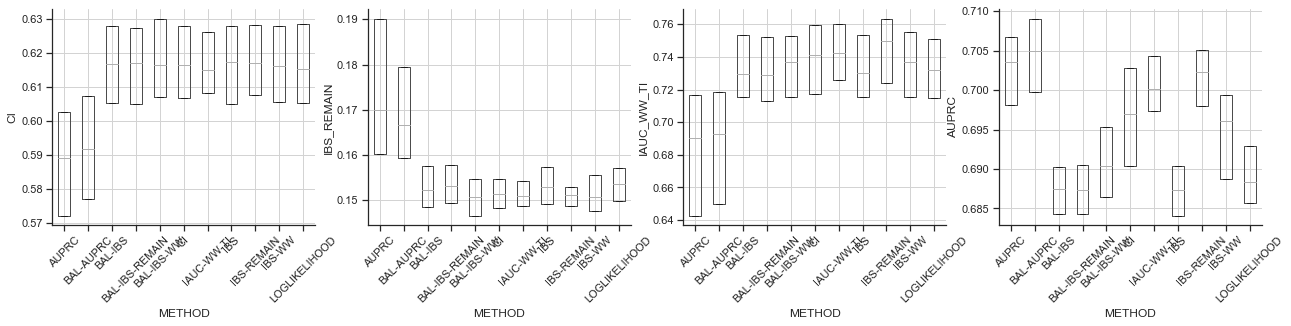

========== PBC ==========
['CI' 'IBS' 'IBS-WW' 'IBS-REMAIN' 'AUPRC' 'IAUC-WW-TI' 'LOGLIKELIHOOD'
 'BAL-AUPRC' 'BAL-IBS' 'BAL-IBS-WW' 'BAL-IBS-REMAIN']
                             CI       IBS_REMAIN       IAUC_WW_TI  \
METHOD                                                              
AUPRC                     0.666           0.1392           0.8097   
BAL-AUPRC                0.6684           0.1332           0.8214   
BAL-IBS                  0.6916           0.1137           0.8597   
BAL-IBS-REMAIN            0.692            0.114           0.8606   
BAL-IBS-WW      \textbf{0.6937}           0.1138           0.8652   
CI              \textbf{0.6993}   \textbf{0.113}  \textbf{0.8724}   
IAUC-WW-TI      \textbf{0.6963}           0.1138  \textbf{0.8735}   
IBS                      0.6921            0.114           0.8599   
IBS-REMAIN               0.6934  \textbf{0.1126}  \textbf{0.8678}   
IBS-WW                   0.6895           0.1135           0.8601   
LOGLIKELIHOOD        

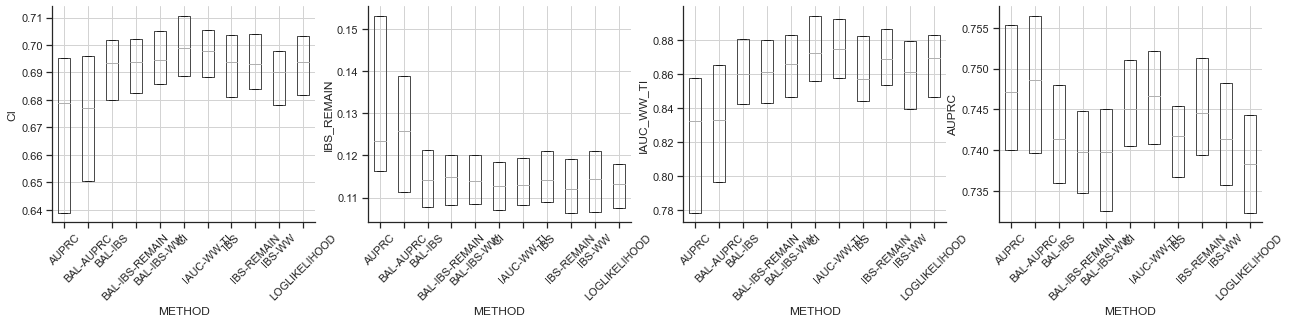

========== rott2 ==========
['CI' 'IBS' 'IBS-WW' 'IBS-REMAIN' 'AUPRC' 'IAUC-WW-TI' 'LOGLIKELIHOOD'
 'BAL-AUPRC' 'BAL-IBS' 'BAL-IBS-WW' 'BAL-IBS-REMAIN']
                             CI       IBS_REMAIN       IAUC_WW_TI  \
METHOD                                                              
AUPRC                    0.6435           0.1256           0.7434   
BAL-AUPRC                0.6473           0.1246           0.7451   
BAL-IBS                  0.6666           0.1185           0.7408   
BAL-IBS-REMAIN           0.6641           0.1192           0.7341   
BAL-IBS-WW      \textbf{0.6688}  \textbf{0.1173}            0.745   
CI                        0.668           0.1192  \textbf{0.7621}   
IAUC-WW-TI               0.6622           0.1212  \textbf{0.7633}   
IBS                      0.6664           0.1186           0.7404   
IBS-REMAIN      \textbf{0.6695}  \textbf{0.1173}  \textbf{0.7491}   
IBS-WW           \textbf{0.669}  \textbf{0.1173}           0.7452   
LOGLIKELIHOOD      

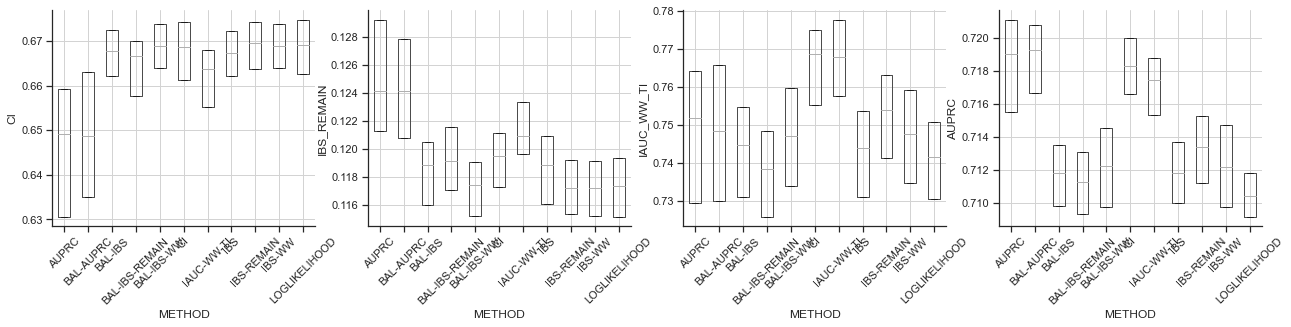

========== WUHAN ==========
['CI' 'IBS' 'IBS-WW' 'IBS-REMAIN' 'AUPRC' 'IAUC-WW-TI' 'LOGLIKELIHOOD'
 'BAL-AUPRC' 'BAL-IBS' 'BAL-IBS-WW' 'BAL-IBS-REMAIN']
                             CI       IBS_REMAIN       IAUC_WW_TI  \
METHOD                                                              
AUPRC                    0.7055           0.0968            0.824   
BAL-AUPRC                0.7017           0.0962           0.8163   
BAL-IBS                  0.7463           0.0761           0.8403   
BAL-IBS-REMAIN           0.7378           0.0785           0.8422   
BAL-IBS-WW                0.756  \textbf{0.0711}           0.8508   
CI              \textbf{0.7634}           0.0735  \textbf{0.8586}   
IAUC-WW-TI                0.747           0.0767           0.8505   
IBS                       0.749           0.0758           0.8429   
IBS-REMAIN      \textbf{0.7562}   \textbf{0.071}  \textbf{0.8508}   
IBS-WW          \textbf{0.7561}  \textbf{0.0711}  \textbf{0.8508}   
LOGLIKELIHOOD      

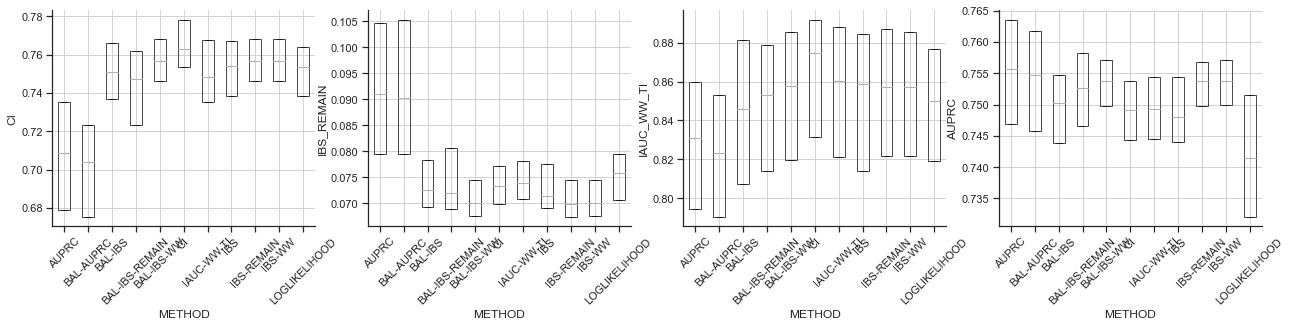

========== smarto ==========
['CI' 'IBS' 'IBS-WW' 'IBS-REMAIN' 'AUPRC' 'IAUC-WW-TI' 'LOGLIKELIHOOD'
 'BAL-AUPRC' 'BAL-IBS' 'BAL-IBS-WW' 'BAL-IBS-REMAIN']
                             CI       IBS_REMAIN       IAUC_WW_TI  \
METHOD                                                              
AUPRC                    0.6305           0.1551           0.6033   
BAL-AUPRC                 0.644           0.1524           0.6221   
BAL-IBS                  0.7144  \textbf{0.1394}  \textbf{0.6684}   
BAL-IBS-REMAIN           0.7152           0.1418           0.6613   
BAL-IBS-WW               0.7169           0.1409           0.6623   
CI              \textbf{0.7313}           0.1434           0.6485   
IAUC-WW-TI                0.714  \textbf{0.1395}  \textbf{0.6689}   
IBS                       0.709           0.1458            0.652   
IBS-REMAIN               0.7151  \textbf{0.1395}  \textbf{0.6667}   
IBS-WW          \textbf{0.7227}           0.1408           0.6627   
LOGLIKELIHOOD   \t

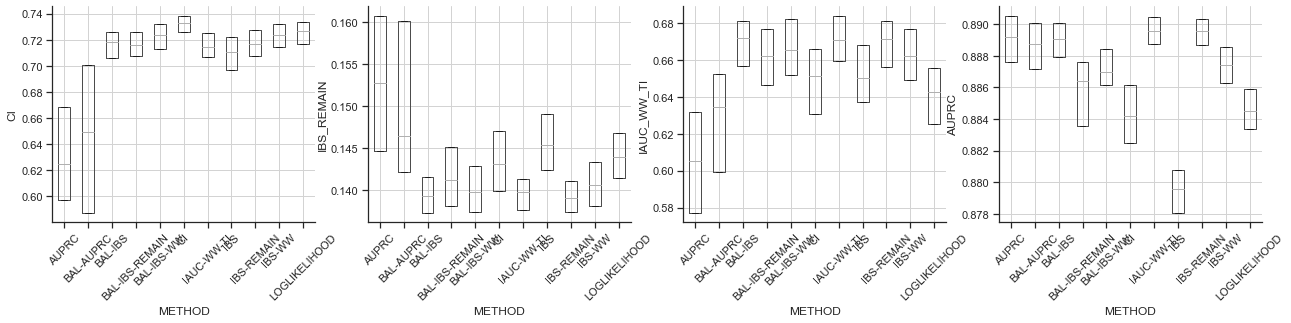

========== support2 ==========
['CI' 'IBS' 'IBS-WW' 'IBS-REMAIN' 'AUPRC' 'IAUC-WW-TI' 'LOGLIKELIHOOD'
 'BAL-AUPRC' 'BAL-IBS' 'BAL-IBS-WW' 'BAL-IBS-REMAIN']
                             CI       IBS_REMAIN       IAUC_WW_TI  \
METHOD                                                              
AUPRC                    0.7914           0.1123           0.8721   
BAL-AUPRC                0.7923           0.1114           0.8764   
BAL-IBS                   0.805           0.0983           0.8983   
BAL-IBS-REMAIN           0.8045           0.0986           0.8984   
BAL-IBS-WW      \textbf{0.8062}           0.0979  \textbf{0.8989}   
CI               \textbf{0.807}           0.0986           0.8982   
IAUC-WW-TI      \textbf{0.8062}           0.0978  \textbf{0.9004}   
IBS                      0.8052  \textbf{0.0974}  \textbf{0.8993}   
IBS-REMAIN               0.8055  \textbf{0.0973}           0.8985   
IBS-WW                   0.8055  \textbf{0.0973}           0.8985   
LOGLIKELIHOOD   

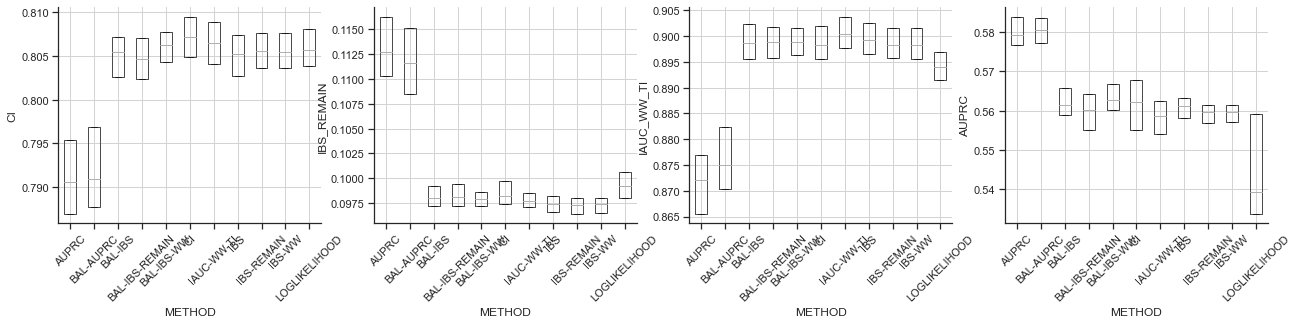

In [14]:
METHOD_MAP = {
    "CRAID": "TREE",
    "BootstrapCRAID": "BSTR", 
    "ParallelBootstrapCRAID": "PBSTR",
    "BoostingCRAID": "BOOST", 
    "IBSCleverBoostingCRAID": "BSTR",
    "CoxPHSurvivalAnalysis": "CoxPH",
    "SurvivalTree": "ST",
    "RandomSurvivalForest": "RSF",
    "ComponentwiseGradientBoostingSurvivalAnalysis": "CWGBSA",
    "GradientBoostingSurvivalAnalysis": "GBSA",
    "LeafSurviveAndHazard": "KM"}

def define_name(x):
    m = x["METHOD"]
    s = m.split("_")
    m = METHOD_MAP.get(s[0], s[0])
    if len(s) > 1:
        m = s[1]
#         m += "_" + s[1]
        # m += "_{" + s[1] + "}"
    s = str(x["ens_metric_name"])
    l_m = str(x["l_m"])
    cr = str(x["CRIT"])
#     if len(s) > 0:
# #         return fr"${m}(\lambda={s})$"
#         return fr"${m}({cr})$"
    return m # fr"${m}$"

def find_best_index(df):
    ens_name = df["ens_metric_name"].values[0]
    
    if ens_name in metr.DESCEND_METRICS:
        best_index = df[ens_name + "_CV_mean"].sort_values(ascending=True).index[:5].tolist()
    else:
        best_index = df[ens_name + "_CV_mean"].sort_values(ascending=False).index[:5].tolist()
    return best_index

def add_star_top3(column, filter_self=False):
    if filter_self:
        top3_index = column[column.index != column.name.replace('_', '-')].argsort()
    else:
        top3_index = column.argsort()
        
    if column.name.split("_")[0] in metr.DESCEND_METRICS:
        top3_index = top3_index[:3]
    else:
        top3_index = top3_index[-3:]
    column.iloc[top3_index] = "\\textbf{" + column.iloc[top3_index].astype(str) + "}"
    return column

def pair_compare_load(dataset, group, ch_met):
    dfs = []
    for c_m in ch_met:
        datasets_sc = f"{c_m}_STRATTIME+_EXT10_NORMAL_{group}_PAR_BSTR_ALL_BINS_origin_{dataset}_CV+SAMPLE_best.xlsx"
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        df_sc["METHOD"] = df_sc["METHOD"] + f"_{c_m.replace('_', '-')}"  #+ "_norm"
        dfs.append(df_sc)

    tg_metrs_1 = ["CI", "IBS_REMAIN", "IAUC_WW_TI", "AUPRC"]  # , "LOGLIKELIHOOD"]  # BAL_AUPRC
    tg_metrs = ["CI_mean", "IBS_REMAIN_mean", "IAUC_WW_TI_mean", "AUPRC_mean"]  #, "LOGLIKELIHOOD_mean"]
    new_metrs = tg_metrs_1
    #new_metrs = [r"$CI$", r"$IBS_{RM}$", r"$IAUC_{WW,TI}$", r"$AUPRC$"]  #, r"$LOGLIKELIHOOD$"]  # r"$AUPRC_{BAL}$
    
    df = pd.concat(dfs, ignore_index=True)
    
    df["ens_metric_name"] = df["PARAMS"].apply(lambda x: eval(x).get("ens_metric_name", ""))
    
    df["l_m"] = df["PARAMS"].apply(lambda x: eval(x).get("leaf_model", ""))
    df["METHOD"] = df.apply(define_name, axis=1)
    print(pd.unique(df["METHOD"]))
#     df = df.loc[df.groupby('METHOD')["IBS_REMAIN_CV_mean"].idxmin()]
    df = df.loc[df.groupby('METHOD').apply(find_best_index).sum()]
    
    f, axes = plt.subplots(1, 4, figsize=(21, 4))
    l_df = []
    for i, v in enumerate(tg_metrs_1):
        df[new_metrs[i]] = df[tg_metrs_1[i]]
        v = new_metrs[i]
        df[v] = df[v].apply(lambda x: np.array(list(map(float, x[1:-1].split()))))
        explode_res = df[[v, "METHOD"]].set_index(['METHOD']).apply(lambda x: x.explode()).reset_index()
        l_df.append(explode_res.groupby(by="METHOD").mean())
        axes[i] = explode_res.boxplot(column=v, by="METHOD", figsize=(10, 10), rot=45, ax=axes[i], showfliers=False, whis=0)
        axes[i].set_ylabel(v)
        axes[i].set_title("")
    res_table = pd.concat(l_df, axis=1).astype(float).round(4)
    res_table.columns = list(map(lambda x: x.replace("$",''), res_table.columns))
    res_table = res_table.apply(add_star_top3)
    print(res_table)
    res_table.to_csv(os.path.join(f"./{dataset}_agg.csv"), sep="&")
    plt.suptitle("")
    plt.show()
    return df

# WITHOUT BALANCED METRICS: "BAL_AUPRC", "BAL_IBS", "BAL_IBS_WW", "BAL_IBS_REMAIN"
ch_metrs = ["CI", "IBS", "IBS_WW", "IBS_REMAIN", "AUPRC", "IAUC_WW_TI", "LOGLIKELIHOOD", "BAL_AUPRC", "BAL_IBS", "BAL_IBS_WW", "BAL_IBS_REMAIN"]
for ds in ["GBSG", "PBC", "rott2", "WUHAN", "smarto", "support2"]:
    print("="*10, ds, "="*10)
    df = pair_compare_load(ds, group, ch_metrs)

### ALL MODELS COMPARISON

In [2]:
group = ""
glob_dir_ = "C:/Users/vasiliev/Desktop/PycharmProjects/dev-survivors/experiment_results/phd_normal_res_with_jit"
glob_dir = glob_dir_

========== GBSG ==========
                                     CI IBS_REMAIN IAUC_WW_TI   AUPRC
$CoxPH$                          0.6086     0.1708     0.7234  0.6222
$CoxTime(l=base_zero_after)$     0.6068     0.1698     0.7226  0.6752
$DeepSurv(l=base_zero_after)$    0.6060     0.1686     0.7256  0.6686
$KM$                             0.5000     0.1936     0.4950  0.5915
$LogLogisticAFT$                 0.6116     0.1653     0.7369  0.6164
$LogNormalAFT$                   0.6099     0.1650     0.7342  0.6258
$PBSTR(l=base)$                  0.6150     0.1679     0.7352  0.6748
$PBSTR(l=base_zero_after)$       0.6190     0.1511     0.7420  0.6982
$ST$                             0.5527     0.1878     0.6091  0.6045
$TREE_KMWV(l=base)$              0.5972     0.1783     0.6909  0.6770
$TREE_KMWV(l=base_zero_after)$   0.5972     0.1676     0.7028  0.7115
$WeibullAFT$                     0.6125     0.1681     0.7373  0.6026
$coxccCRAID(l=base_zero_after)$  0.5988     0.1765     0.7114  

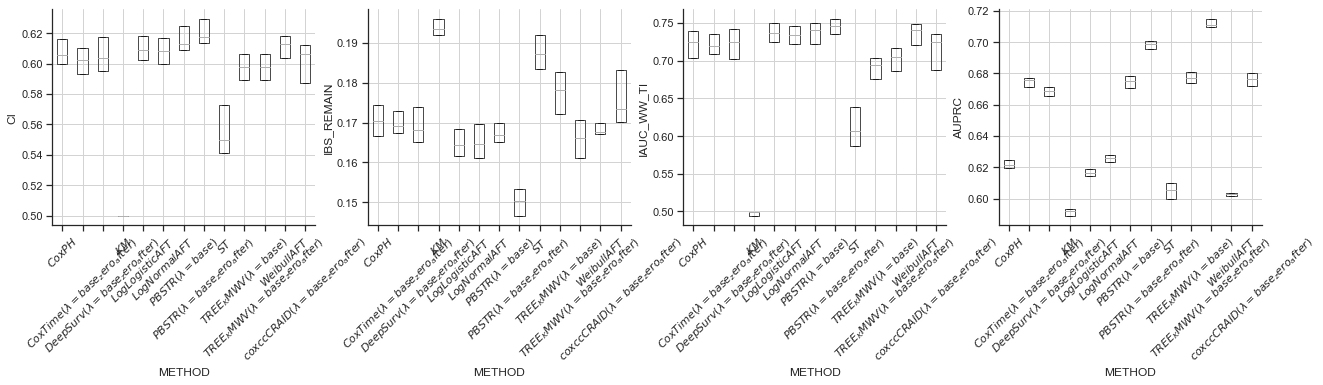

========== PBC ==========
                                     CI IBS_REMAIN IAUC_WW_TI   AUPRC
$CoxPH$                          0.6783     0.1199     0.8621  0.6981
$CoxTime(l=base_zero_after)$     0.6749     0.1238     0.8590  0.7257
$DeepSurv(l=base_zero_after)$    0.6577     0.1348     0.8288  0.7085
$KM$                             0.5000     0.1978     0.4978  0.6086
$LogLogisticAFT$                 0.6799     0.1249     0.8602  0.6844
$LogNormalAFT$                   0.6811     0.1289     0.8570  0.6778
$PBSTR(l=base)$                  0.6844     0.1265     0.8609  0.7186
$PBSTR(l=base_zero_after)$       0.6857     0.1144     0.8500  0.7328
$ST$                             0.5199     0.1948     0.5531  0.6169
$TREE_KMWV(l=base)$              0.6662     0.1359     0.8278  0.7377
$TREE_KMWV(l=base_zero_after)$   0.6619     0.1252     0.8461  0.7661
$WeibullAFT$                     0.6754     0.1264     0.8539  0.6700
$coxccCRAID(l=base_zero_after)$  0.6735     0.1193     0.8690  0

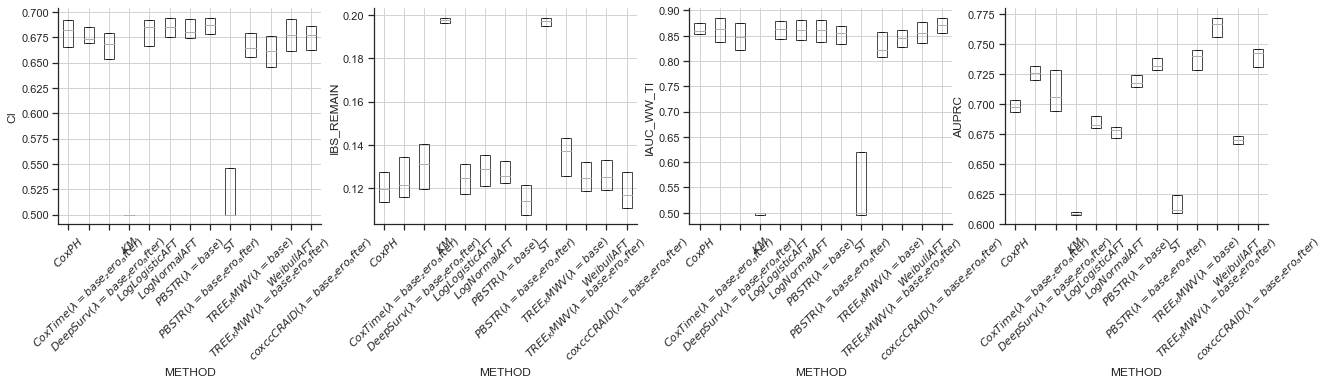

========== rott2 ==========
                                     CI IBS_REMAIN IAUC_WW_TI   AUPRC
$CoxPH$                          0.5960     0.4756     0.7105  0.0000
$CoxTime(l=base_zero_after)$     0.6022     0.1548     0.7203  0.6698
$DeepSurv(l=base_zero_after)$    0.6030     0.1530     0.7257  0.6634
$KM$                             0.5000     0.1791     0.4962  0.5952
$LogLogisticAFT$                 0.6060     0.1531     0.7282  0.6291
$LogNormalAFT$                   0.5964     0.1573     0.7106  0.6252
$PBSTR(l=base)$                  0.6480     0.1535     0.7372  0.6637
$PBSTR(l=base_zero_after)$       0.6703     0.1172     0.7547  0.7145
$ST$                             0.5554     0.1800     0.6185  0.6075
$TREE_KMWV(l=base)$              0.6223     0.1555     0.7285  0.6701
$TREE_KMWV(l=base_zero_after)$   0.6248     0.1281     0.7336  0.7242
$WeibullAFT$                     0.6022     0.1525     0.7187  0.6308
$coxccCRAID(l=base_zero_after)$  0.5942     0.1591     0.7069 

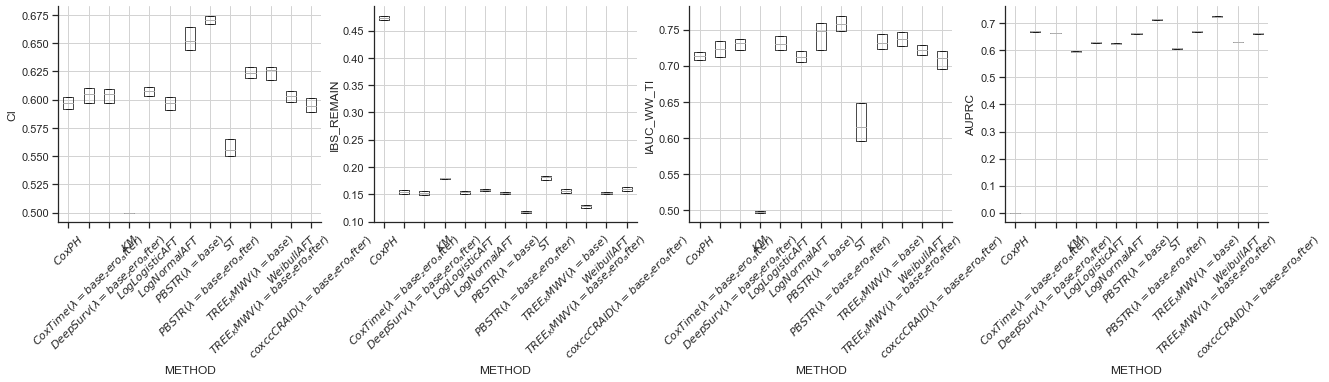

========== WUHAN ==========
                                     CI IBS_REMAIN IAUC_WW_TI   AUPRC
$CoxPH$                          0.7088     0.1256     0.8204  0.7276
$CoxTime(l=base_zero_after)$     0.6650     0.1016     0.8195  0.7333
$DeepSurv(l=base_zero_after)$    0.6710     0.1009     0.8265  0.7408
$KM$                             0.5000     0.1913     0.4871  0.5515
$LogLogisticAFT$                 0.6658     0.1885     0.4871  0.5099
$LogNormalAFT$                   0.6530     0.2401     0.7347  0.6313
$PBSTR(l=base)$                  0.7481     0.0771     0.8449  0.7310
$PBSTR(l=base_zero_after)$       0.7525     0.0724     0.8467  0.7477
$ST$                             0.6363     0.1440     0.7508  0.6514
$TREE_KMWV(l=base)$              0.6994     0.0959     0.8373  0.7459
$TREE_KMWV(l=base_zero_after)$   0.6768     0.1008     0.8235  0.7583
$WeibullAFT$                     0.5000     0.1767     0.4871  0.5567
$coxccCRAID(l=base_zero_after)$  0.6772     0.0932     0.8462 

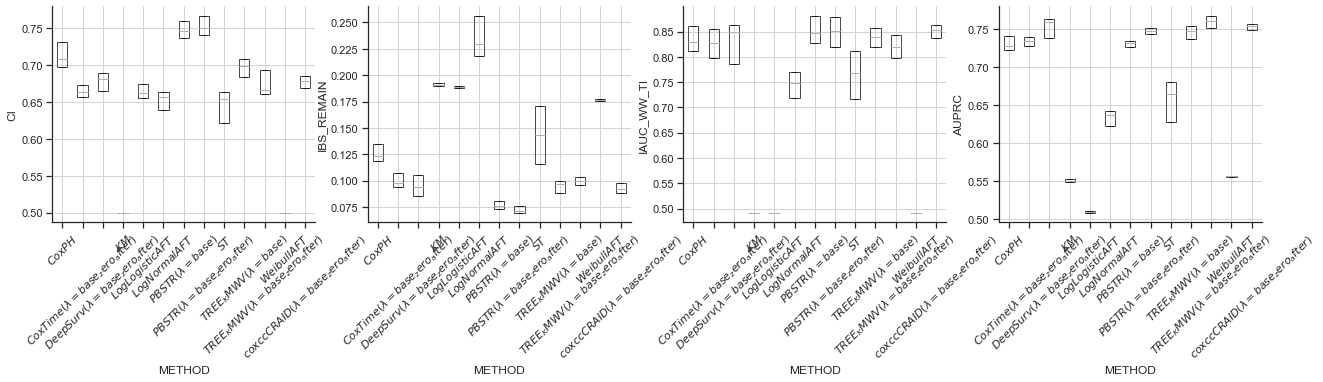

========== smarto ==========
                                     CI IBS_REMAIN IAUC_WW_TI   AUPRC
$CoxPH$                          0.4726     0.1692     0.6463  0.8494
$CoxTime(l=base_zero_after)$     0.5025     0.1738     0.6423  0.8733
$DeepSurv(l=base_zero_after)$    0.4995     0.1684     0.6534  0.8730
$KM$                             0.5000     0.1870     0.4999  0.8406
$LogLogisticAFT$                 0.4700     0.1729     0.6453  0.8465
$LogNormalAFT$                   0.4521     0.1804     0.6289  0.8400
$PBSTR(l=base)$                  0.6944     0.1726     0.6522  0.8721
$PBSTR(l=base_zero_after)$       0.7171     0.1397     0.6669  0.8896
$ST$                             0.4711     0.1843     0.5717  0.8459
$TREE_KMWV(l=base)$              0.5643     0.1760     0.6180  0.8717
$TREE_KMWV(l=base_zero_after)$   0.5748     0.1534     0.6190  0.8902
$WeibullAFT$                     0.5018     0.1692     0.6605  0.8483
$coxccCRAID(l=base_zero_after)$  0.5020     0.1725     0.6441

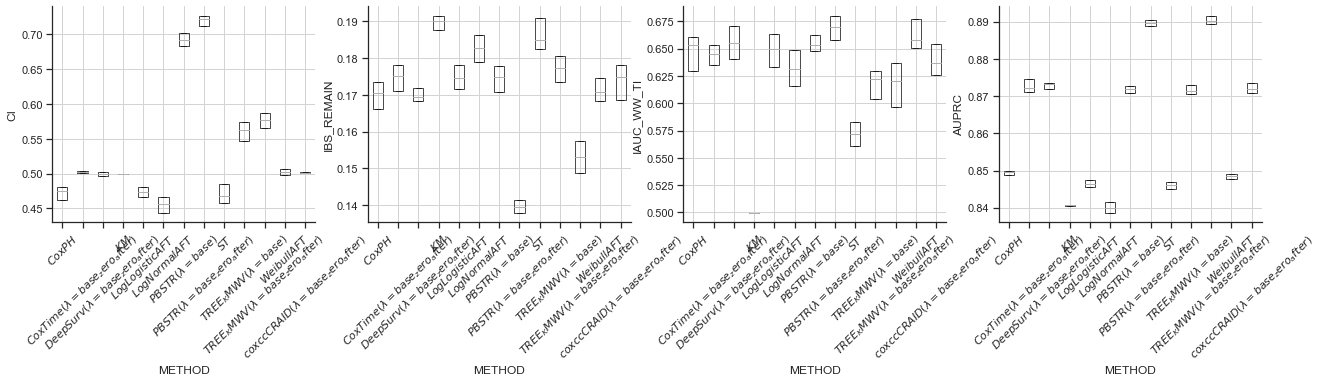

========== support2 ==========
                                     CI IBS_REMAIN IAUC_WW_TI   AUPRC
$CoxPH$                          0.7860     0.1260     0.8623  0.4641
$CoxTime(l=base_zero_after)$     0.7988     0.1022     0.8927  0.5193
$DeepSurv(l=base_zero_after)$    0.8010     0.1002     0.8972  0.5412
$KM$                             0.5000     0.1777     0.4999  0.2780
$LogLogisticAFT$                 0.7892     0.1088     0.8679  0.4692
$LogNormalAFT$                   0.7891     0.1087     0.8703  0.4705
$PBSTR(l=base)$                  0.8073     0.1013     0.8966  0.5106
$PBSTR(l=base_zero_after)$       0.8070     0.0992     0.8963  0.5420
$ST$                             0.7492     0.1240     0.8442  0.4550
$TREE_KMWV(l=base)$              0.7997     0.1034     0.8888  0.5417
$TREE_KMWV(l=base_zero_after)$   0.8017     0.1053     0.8902  0.5858
$WeibullAFT$                     0.7888     0.1171     0.8708  0.4559
$coxccCRAID(l=base_zero_after)$  0.7991     0.1025     0.89

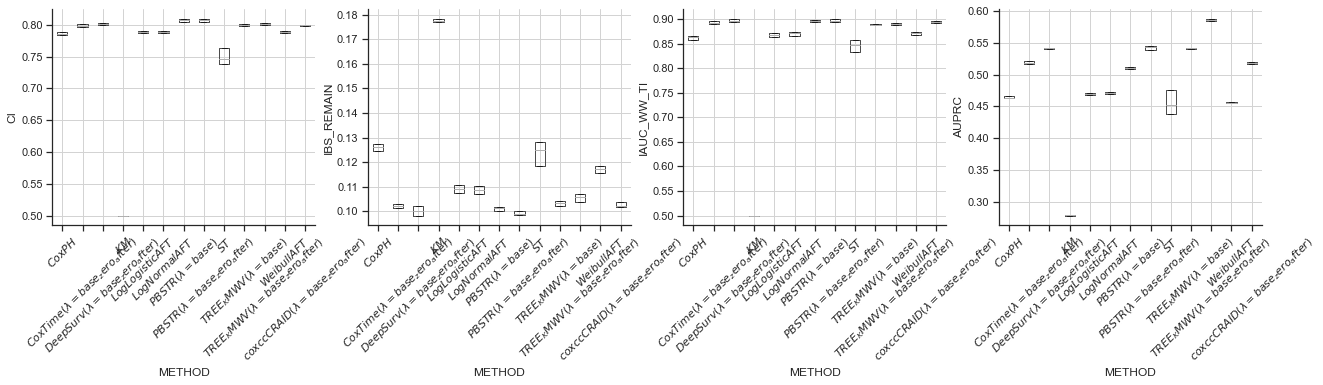

In [3]:
METHOD_MAP = {
    "CRAID": "TREE",
    "BootstrapCRAID": "BSTR", 
    "ParallelBootstrapCRAID": "PBSTR",
    "BoostingCRAID": "BOOST", 
    "IBSCleverBoostingCRAID": "BSTR",
    "CoxPHSurvivalAnalysis": "CoxPH",
    "SurvivalTree": "ST",
    "RandomSurvivalForest": "RSF",
    "ComponentwiseGradientBoostingSurvivalAnalysis": "CWGBSA",
    "GradientBoostingSurvivalAnalysis": "GBSA",
    "LeafSurviveAndHazard": "KM",
    "BaseLeafModeLL": "KM",
    "deepsurvCRAID": "DeepSurv",
    "coxtimeCRAID": "CoxTime"}

STAT_m = ['BaseLeafModeLL']
ML_m = ["CoxPH", 'ST']
SELF_m = ['TREE', 'TREE_KMWV']

def define_name(x):
    m = x["METHOD"]
    s = m.split("_")
    m = METHOD_MAP.get(s[0], s[0])
    if len(s) > 1:
#         m = s[1]
        m += "_" + s[1]
        # m += "_{" + s[1] + "}"
    s = str(x["ens_metric_name"])
    l_m = str(x["l_m"])
    cr = str(x["CRIT"])
    if len(s) > 0:
        return fr"${m}(\lambda={l_m})$"
#         return fr"${m}({cr})$"
    return fr"${m}$"

def find_best_index(df):
    ens_name = "IBS_REMAIN" # df["ens_metric_name"].values[0]
    #ens_name = ens_name.replace("conc", "CI")
    #ens_name = ens_name.replace("likelihood", "LOGLIKELIHOOD")
    
    if ens_name in metr.DESCEND_METRICS:
        best_index = df[ens_name + "_CV_mean"].sort_values(ascending=True).index[:5].tolist()
    else:
        best_index = df[ens_name + "_CV_mean"].sort_values(ascending=False).index[:5].tolist()
    return best_index

def add_star_top3(column, filter_self=False):
    if filter_self:
        top_index = column[column.index != column.name.replace('_', '-')].argsort()
    else:
        top_index = column.argsort()
        
    if column.name.split("_")[0] in metr.DESCEND_METRICS:
        top3_index = top_index[:3]
    else:
        top3_index = top_index[-3:]
    column.iloc[top3_index] = "\\textbf{" + column.iloc[top3_index].astype(str) + "}"
    return column

def rank_values(column, filter_self=False):
    top_index = column.argsort().argsort()
    if column.name.split("_")[0] in metr.DESCEND_METRICS:
        return top_index + 1
    return top_index.shape[0] - top_index

def pair_compare_load(dataset, group, ch_met):
    dfs = []
    for c_m in ch_met:        
        datasets_sc = f"{c_m}_TREE_{dataset}_CV+SAMPLE_best.xlsx"
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        df_sc["METHOD"] = df_sc["METHOD"]  + "_KMWV"
        dfs.append(df_sc)        
        
        datasets_sc = f"{c_m}_PARBSTR_{dataset}_CV+SAMPLE_best.xlsx"
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        dfs.append(df_sc)
        
        datasets_sc = f"LOGLIKELIHOOD_STRATTIME+_scsurv_extended_no_scale_{dataset}_CV+SAMPLE_best.xlsx"  # scsurv models
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
#         df_sc = df_sc[df_sc["METHOD"].isin(["BaseLeafModeLL", "CoxPHSurvivalAnalysis", "SurvivalTree"])]
        dfs.append(df_sc)
    
        datasets_sc = f"extra_datasets_experiments_{dataset}_CV+SAMPLE_best.xlsx"
        dfs.append(pd.read_excel(os.path.join(os.path.split(glob_dir)[0], "PyCox", datasets_sc)))

    tg_metrs_1 = ["CI", "IBS_REMAIN", "IAUC_WW_TI", "AUPRC"]  # , "LOGLIKELIHOOD"]  # BAL_AUPRC
    tg_metrs = ["CI_mean", "IBS_REMAIN_mean", "IAUC_WW_TI_mean", "AUPRC_mean"]  #, "LOGLIKELIHOOD_mean"]
    new_metrs = tg_metrs_1
    
    df = pd.concat(dfs, ignore_index=True)
    
    df["ens_metric_name"] = df["PARAMS"].apply(lambda x: eval(x).get("ens_metric_name", ""))
    
    df["l_m"] = df["PARAMS"].apply(lambda x: eval(x).get("leaf_model", ""))  # l_reg
    # df = df[df["l_m"] != "base_fast"][tg_metrs_1 + ["METHOD", "ens_metric_name", "CRIT"]]
    
    # df = df[tg_metrs_1 + ["METHOD", "ens_metric_name", "CRIT", "l_m", "IBS_REMAIN_CV_mean"]]
#     df = df[~df["METHOD"].isin(["CoxPH", "RSF", "GBSA", "CWGBSA"])]
#     df = df[df["ens_metric_name"].isin({0.0, ""})]
    df["METHOD"] = df.apply(define_name, axis=1)  # "(" + df["ens_metric_name"] + ")"
    df = df[~df["METHOD"].isin(["$RSF$", "$GBSA$", "$CWGBSA$"])]
#     df = df[~df["METHOD"].isin(["KM", "coxccCRAID", 'BaseLeafModeLL_ext', '$WeibullAFT$', '$LogLogisticAFT$'])]
#     df = df[~df["METHOD"].isin(["$KM_{NEW}$", '$WeibullAFT_{NEW}$', '$LogLogisticAFT_{NEW}$'])]

#     df = df[~df["METHOD"].isin(["$RSF$", "$GBSA$", "$CWGBSA$"])]  # "$CoxPH$", 
#     df["METHOD"] = df["METHOD"].apply(lambda x: fr'$\bf{"{" + x + "}$"}' if x.find("_") != -1 else x)
    df = df.loc[df.groupby('METHOD')["IBS_REMAIN_CV_mean"].idxmin()]
    df["METHOD"] = df["METHOD"].astype("category")
#     df["METHOD"] = df["METHOD"].cat.set_categories(["$KM$", "$CoxPH$", "$ST$"] + list(df["METHOD"].unique()[3:]))
#     df["METHOD"] = df["METHOD"].cat.set_categories(list(df["METHOD"].unique()[:3]) + list(df["METHOD"].unique()[3:]))
    
#     df = df.loc[df.groupby('METHOD').apply(find_best_index).sum()]
    
    f, axes = plt.subplots(1, 4, figsize=(21, 4))
    l_df = []
#     print(df[["TIME", "METHOD"]].groupby(by="METHOD").min())
    for i, v in enumerate(tg_metrs_1):
#         df[new_metrs[i]] = df[tg_metrs[i]]
#         sns.boxplot(data=df, x="METHOD", y=new_metrs[i], palette='deep', ax=axes[i])
#         df.boxplot(x="METHOD", y=new_metrs[i], ax=axes[i])
#         axes[i].tick_params(axis='x', rotation=45)
        df[new_metrs[i]] = df[tg_metrs_1[i]]
        v = new_metrs[i]
        df[v] = df[v].apply(lambda x: np.array(list(map(float, x[1:-1].split()))))
        explode_res = df[[v, "METHOD"]].set_index(['METHOD']).apply(lambda x: x.explode()).reset_index()
        #l_df.append(explode_res.groupby(by="METHOD").mean().astype(str) + " +- " + explode_res.groupby(by="METHOD").std().astype(str))
#         l_df.append(explode_res.groupby(by="METHOD").agg(lambda x: f"{x.mean():.3f}+-{x.std():.3f}"))
        l_df.append(explode_res.groupby(by="METHOD").agg(lambda x: f"{x.mean():.4f}"))
        axes[i] = explode_res.boxplot(column=v, by="METHOD", figsize=(10, 10), rot=45, ax=axes[i], showfliers=False, whis=0)
        axes[i].set_ylabel(v)
        axes[i].set_title("")
    res_table = pd.concat(l_df, axis=1)#.astype(float).round(4)
    res_table.index = list(map(lambda x: x.replace("\lambda",'l'), res_table.index))
    res_table.columns = list(map(lambda x: x.replace("$",''), res_table.columns))
#     res_table.index = "$" + res_table.index + "$"
    
    print(res_table)
    res_table_star = res_table.copy()
#     res_table_star = res_table_star.apply(add_star_top3)
    res_table_star.to_csv(os.path.join(glob_dir, f"{dataset}_agg.csv"), sep="&")
    plt.suptitle("")
    plt.show()
    return res_table.apply(rank_values) # df

# "IAUC_WW_TI",
# ch_metrs = ["CI", "IBS", "IBS_WW", "IBS_REMAIN", "AUPRC", "BAL_AUPRC", "BAL_IBS", "IAUC_WW_TI", "LOGLIKELIHOOD", "BAL_IBS_WW", "BAL_IBS_REMAIN"]  # ["likelihood", "conc", "IBS", "IBS_WW", "IBS_REMAIN"]
ch_metrs = ["IBS_REMAIN"]
df_l = []
for ds in ["GBSG", "PBC", "rott2", "WUHAN", "smarto", "support2"]: # , "WUHAN", "rott2", "GBSG", "PBC", "smarto", "support2"]:
    print("="*10, ds, "="*10)
    df = pair_compare_load(ds, group, ch_metrs)
    df_l.append(df)

In [5]:
group = "EQ_REG" # "STAT_AGILE_CLEVERBOOST"  # "bstr_full_WB", "EQ_REG_TREE_ALL_BINS"
# glob_dir_ = "C:/Users/vasiliev/Desktop/PycharmProjects/dev-survivors/experiment_results/many_ds/"  # EXT10/
glob_dir_ = "C:/Users/vasiliev/Desktop/PycharmProjects/dev-survivors/experiment_results/phd_normal_res_new_with_jit"
glob_dir = glob_dir_  # os.path.join(glob_dir_, group)

========== GBSG ==========
                            CI    IBS_REMAIN    IAUC_WW_TI         AUPRC
$BaseLeafModeLL$  0.500+-0.000  0.194+-0.002  0.495+-0.008  0.591+-0.003
$CoxPH$           0.609+-0.016  0.171+-0.004  0.723+-0.030  0.622+-0.004
$LogLogisticAFT$  0.612+-0.015  0.165+-0.004  0.737+-0.026  0.616+-0.002
$LogNormalAFT$    0.610+-0.015  0.165+-0.005  0.734+-0.028  0.626+-0.003
$WeibullAFT$      0.612+-0.014  0.168+-0.003  0.737+-0.024  0.603+-0.002
$ST$              0.553+-0.021  0.188+-0.006  0.609+-0.038  0.605+-0.007
$RSF$             0.616+-0.013  0.172+-0.003  0.733+-0.024  0.610+-0.003
$CWGBSA$          0.581+-0.019  0.184+-0.002  0.690+-0.025  0.599+-0.003
$GBSA$            0.613+-0.013  0.173+-0.003  0.728+-0.025  0.608+-0.003
$DeepSurv$        0.606+-0.020  0.169+-0.005  0.726+-0.030  0.669+-0.005
$CoxTime$         0.607+-0.021  0.170+-0.005  0.723+-0.033  0.675+-0.005
$TREE_KMWV$       0.599+-0.019  0.165+-0.008  0.708+-0.033  0.709+-0.004
$BSTR$            0.619+

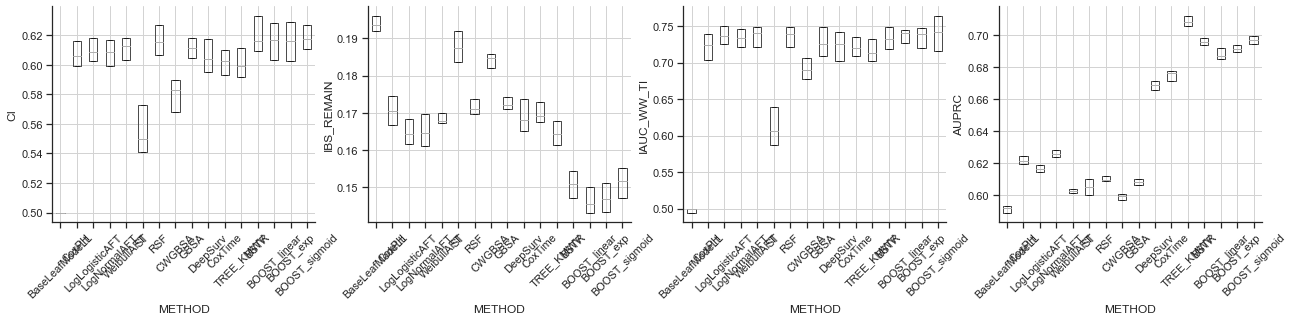

========== PBC ==========
                            CI    IBS_REMAIN    IAUC_WW_TI         AUPRC
$BaseLeafModeLL$  0.500+-0.000  0.198+-0.002  0.498+-0.004  0.609+-0.002
$CoxPH$           0.678+-0.019  0.120+-0.009  0.862+-0.026  0.698+-0.006
$LogLogisticAFT$  0.680+-0.020  0.125+-0.010  0.860+-0.027  0.684+-0.006
$LogNormalAFT$    0.681+-0.019  0.129+-0.010  0.857+-0.026  0.678+-0.008
$WeibullAFT$      0.675+-0.022  0.126+-0.010  0.854+-0.032  0.670+-0.005
$ST$              0.520+-0.038  0.195+-0.011  0.553+-0.080  0.617+-0.011
$RSF$             0.677+-0.018  0.133+-0.006  0.868+-0.027  0.661+-0.005
$CWGBSA$          0.648+-0.031  0.190+-0.003  0.820+-0.063  0.612+-0.002
$GBSA$            0.646+-0.023  0.188+-0.002  0.820+-0.031  0.614+-0.002
$DeepSurv$        0.658+-0.039  0.135+-0.020  0.829+-0.075  0.709+-0.025
$CoxTime$         0.675+-0.013  0.124+-0.012  0.859+-0.029  0.726+-0.009
$TREE_KMWV$       0.659+-0.019  0.125+-0.011  0.847+-0.028  0.763+-0.010
$BSTR$            0.672+-

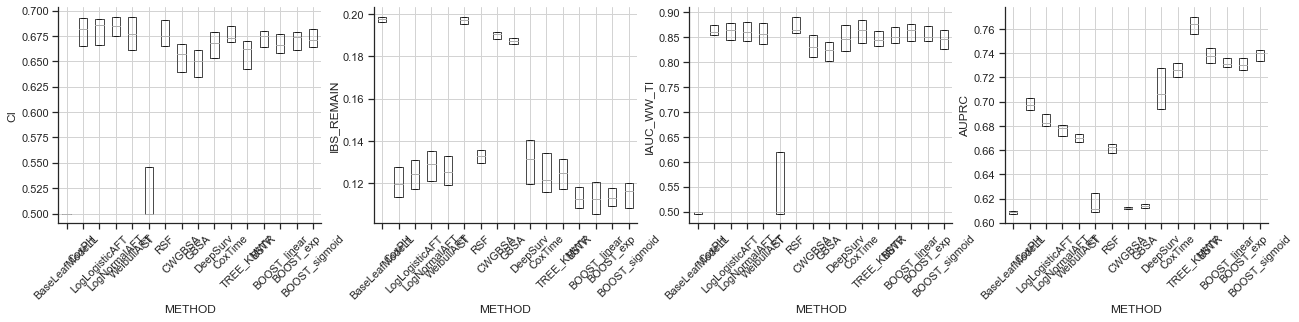

========== rott2 ==========
                            CI    IBS_REMAIN    IAUC_WW_TI         AUPRC
$BaseLeafModeLL$  0.500+-0.000  0.179+-0.002  0.496+-0.004  0.595+-0.003
$CoxPH$           0.596+-0.009  0.476+-0.010  0.710+-0.018  0.000+-0.000
$LogLogisticAFT$  0.606+-0.009  0.153+-0.003  0.728+-0.017  0.629+-0.002
$LogNormalAFT$    0.596+-0.008  0.157+-0.003  0.711+-0.017  0.625+-0.002
$WeibullAFT$      0.602+-0.009  0.153+-0.004  0.719+-0.017  0.631+-0.002
$ST$              0.555+-0.018  0.180+-0.007  0.619+-0.031  0.607+-0.005
$RSF$             0.599+-0.008  0.164+-0.002  0.727+-0.017  0.608+-0.004
$CWGBSA$          0.609+-0.010  0.154+-0.003  0.730+-0.018  0.629+-0.003
$GBSA$            0.619+-0.010  0.146+-0.004  0.747+-0.021  0.638+-0.004
$DeepSurv$        0.603+-0.011  0.153+-0.004  0.726+-0.020  0.663+-0.002
$CoxTime$         0.602+-0.010  0.155+-0.005  0.720+-0.022  0.670+-0.003
$TREE_KMWV$       0.619+-0.010  0.128+-0.004  0.735+-0.017  0.723+-0.003
$BSTR$            0.649

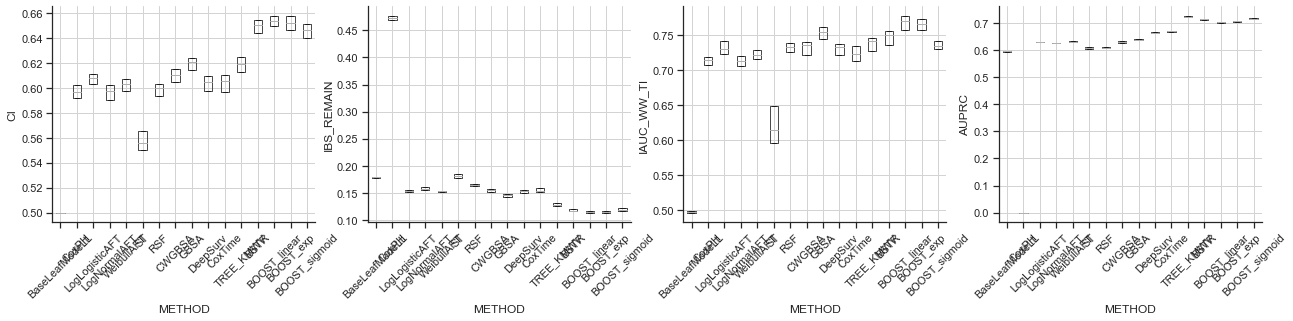

========== WUHAN ==========
                            CI    IBS_REMAIN    IAUC_WW_TI         AUPRC
$BaseLeafModeLL$  0.500+-0.000  0.191+-0.002  0.487+-0.013  0.551+-0.003
$CoxPH$           0.709+-0.028  0.126+-0.014  0.820+-0.061  0.728+-0.018
$LogLogisticAFT$  0.666+-0.018  0.188+-0.002  0.487+-0.013  0.510+-0.002
$LogNormalAFT$    0.653+-0.019  0.240+-0.031  0.735+-0.048  0.631+-0.018
$WeibullAFT$      0.500+-0.000  0.177+-0.002  0.487+-0.013  0.557+-0.001
$ST$              0.636+-0.045  0.144+-0.034  0.751+-0.088  0.651+-0.038
$RSF$             0.683+-0.012  0.088+-0.004  0.823+-0.046  0.679+-0.005
$CWGBSA$          0.692+-0.012  0.094+-0.005  0.830+-0.049  0.675+-0.005
$GBSA$            0.681+-0.011  0.099+-0.005  0.802+-0.042  0.662+-0.003
$DeepSurv$        0.671+-0.026  0.101+-0.024  0.827+-0.056  0.741+-0.039
$CoxTime$         0.665+-0.013  0.102+-0.013  0.819+-0.052  0.733+-0.008
$TREE_KMWV$       0.693+-0.019  0.101+-0.010  0.822+-0.041  0.757+-0.011
$BSTR$            0.731

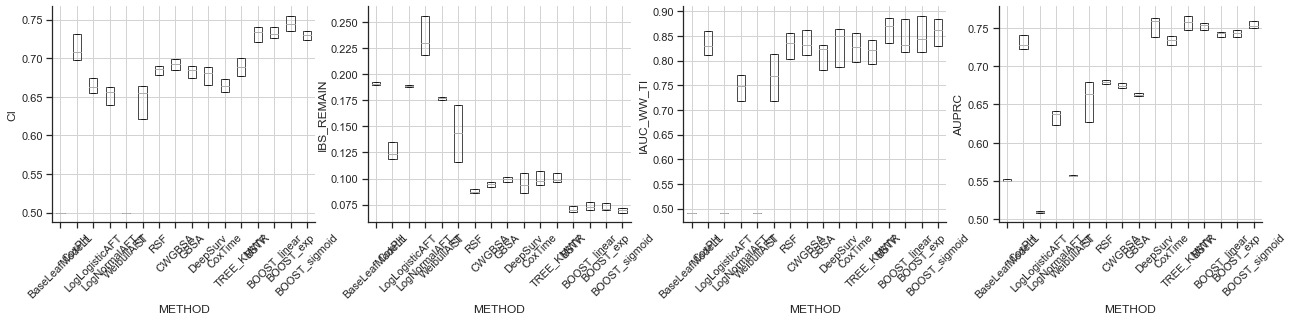

========== smarto ==========
                            CI    IBS_REMAIN    IAUC_WW_TI         AUPRC
$BaseLeafModeLL$  0.500+-0.000  0.187+-0.007  0.500+-0.000  0.841+-0.000
$CoxPH$           0.473+-0.014  0.169+-0.007  0.646+-0.022  0.849+-0.001
$LogLogisticAFT$  0.470+-0.018  0.173+-0.008  0.645+-0.022  0.846+-0.001
$LogNormalAFT$    0.452+-0.020  0.180+-0.009  0.629+-0.026  0.840+-0.001
$WeibullAFT$      0.502+-0.007  0.169+-0.007  0.661+-0.019  0.848+-0.001
$ST$              0.471+-0.022  0.184+-0.009  0.572+-0.018  0.846+-0.001
$RSF$             0.491+-0.010  0.183+-0.007  0.638+-0.018  0.842+-0.000
$CWGBSA$          0.514+-0.009  0.179+-0.007  0.641+-0.024  0.843+-0.001
$GBSA$            0.571+-0.008  0.171+-0.006  0.663+-0.021  0.869+-0.001
$DeepSurv$        0.499+-0.004  0.168+-0.007  0.653+-0.020  0.873+-0.001
$CoxTime$         0.503+-0.003  0.174+-0.008  0.642+-0.018  0.873+-0.004
$TREE_KMWV$       0.549+-0.013  0.153+-0.006  0.619+-0.027  0.890+-0.002
$BSTR$            0.59

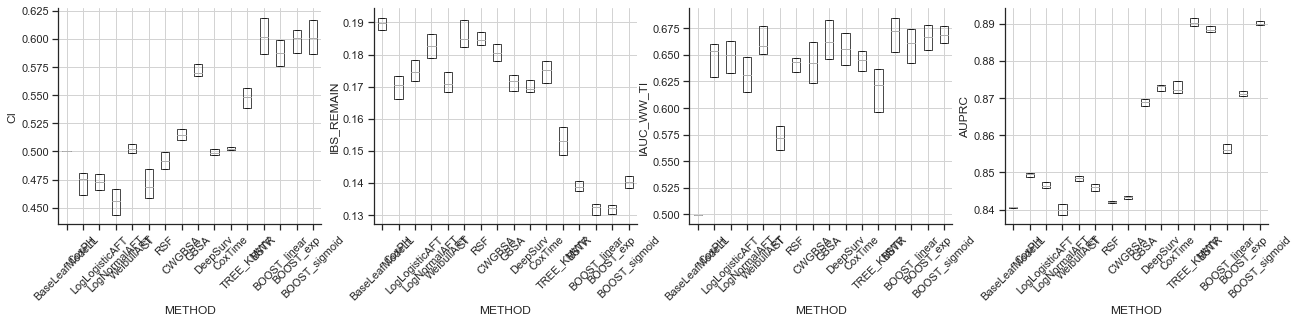

========== support2 ==========
                            CI    IBS_REMAIN    IAUC_WW_TI         AUPRC
$BaseLeafModeLL$  0.500+-0.000  0.178+-0.001  0.500+-0.000  0.278+-0.000
$CoxPH$           0.786+-0.003  0.126+-0.002  0.862+-0.005  0.464+-0.002
$LogLogisticAFT$  0.789+-0.003  0.109+-0.002  0.868+-0.005  0.469+-0.002
$LogNormalAFT$    0.789+-0.003  0.109+-0.002  0.870+-0.005  0.470+-0.002
$WeibullAFT$      0.789+-0.003  0.117+-0.002  0.871+-0.005  0.456+-0.002
$ST$              0.749+-0.015  0.124+-0.007  0.844+-0.017  0.455+-0.023
$RSF$             0.791+-0.003  0.129+-0.001  0.881+-0.004  0.359+-0.002
$CWGBSA$          0.748+-0.002  0.128+-0.002  0.818+-0.004  0.396+-0.001
$GBSA$            0.803+-0.003  0.099+-0.002  0.893+-0.004  0.520+-0.002
$DeepSurv$        0.801+-0.003  0.100+-0.002  0.897+-0.004  0.541+-0.002
$CoxTime$         0.799+-0.003  0.102+-0.002  0.893+-0.004  0.519+-0.004
$TREE_KMWV$       0.802+-0.003  0.105+-0.002  0.891+-0.004  0.586+-0.002
$BSTR$            0.

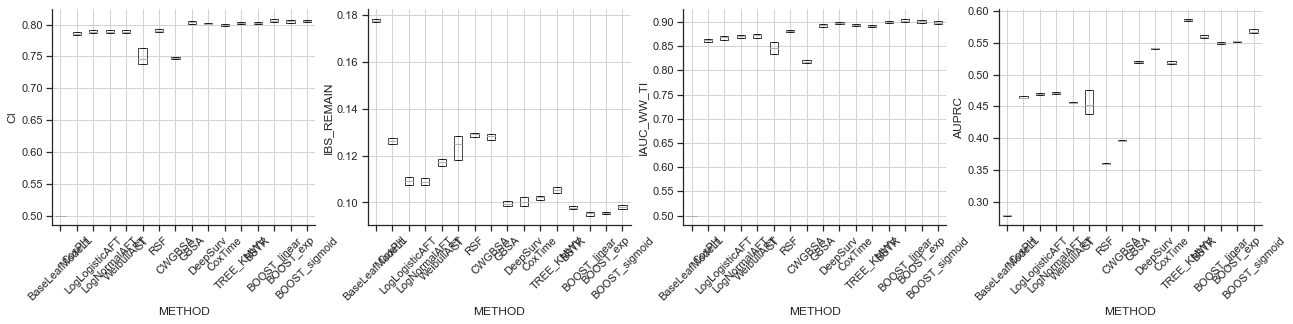

In [7]:
METHOD_MAP = {
    "CRAID": "TREE",
    "BootstrapCRAID": "BSTR", 
    "ParallelBootstrapCRAID": "PBSTR",
    "BoostingCRAID": "BOOST", 
    "IBSCleverBoostingCRAID": "BSTR",
    "CoxPHSurvivalAnalysis": "CoxPH",
    "SurvivalTree": "ST",
    "RandomSurvivalForest": "RSF",
    "ComponentwiseGradientBoostingSurvivalAnalysis": "CWGBSA",
    "GradientBoostingSurvivalAnalysis": "GBSA",
    "LeafSurviveAndHazard": "KM",
    "deepsurvCRAID": "DeepSurv",
    "coxtimeCRAID": "CoxTime"}

STAT_m = ['BaseLeafModeLL', "CoxPH", 'LogLogisticAFT', 'LogNormalAFT', "WeibullAFT"]
ML_m = ['ST', 'RSF', 'CWGBSA', 'GBSA']
NN_m = ['DeepSurv', 'CoxTime']
SELF_m = ['TREE_KMWV', 'BSTR', 'BOOST_linear', 'BOOST_exp', 'BOOST_sigmoid']

def define_name(x):
    m = x["METHOD"]
    s = m.split("_")
    m = METHOD_MAP.get(s[0], s[0])
    if len(s) > 1:
#         m = s[1]
        m += "_" + s[1]
        # m += "_{" + s[1] + "}"
    s = str(x["ens_metric_name"])
    l_m = str(x["l_m"])
    cr = str(x["CRIT"])
#     if len(s) > 0:
# #         return fr"${m}(\lambda={s})$"
#         return fr"${m}({cr})$"
    return m # fr"${m}$"

def find_best_index(df):
    ens_name = "IBS_REMAIN" # df["ens_metric_name"].values[0]
    #ens_name = ens_name.replace("conc", "CI")
    #ens_name = ens_name.replace("likelihood", "LOGLIKELIHOOD")
    
    if ens_name in metr.DESCEND_METRICS:
        best_index = df[ens_name + "_CV_mean"].sort_values(ascending=True).index[:5].tolist()
    else:
        best_index = df[ens_name + "_CV_mean"].sort_values(ascending=False).index[:5].tolist()
    return best_index

def add_star_top3(column, filter_self=False):
    if filter_self:
        top_index = column[column.index != column.name.replace('_', '-')].argsort()
    else:
        top_index = column.argsort()
        
    if column.name.split("_")[0] in metr.DESCEND_METRICS:
        top3_index = top_index[:3]
    else:
        top3_index = top_index[-3:]
    column.iloc[top3_index] = "\\textbf{" + column.iloc[top3_index].astype(str) + "}"
    return column

def rank_values(column, filter_self=False):
    top_index = column.argsort().argsort()
    if column.name.split("_")[0] in metr.DESCEND_METRICS:
        return top_index + 1
    return top_index.shape[0] - top_index

def pair_compare_load(dataset, group, ch_met):
    dfs = []
    for c_m in ch_met:
        datasets_sc = f"{c_m}_STRATTIME+_EXT10_NORMAL_{group}_TREE_ALL_BINS_origin_{dataset}_CV+SAMPLE_best.xlsx"
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        df_sc["METHOD"] = df_sc["METHOD"] + "_KMWV"
        dfs.append(df_sc)

#         datasets_sc = f"{c_m}_STRATTIME+_EXT10_NORMAL_{group}_PAR_BSTR_ALL_BINS_origin_{dataset}_CV+SAMPLE_best.xlsx"
#         df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
#         df_sc["METHOD"] = df_sc["METHOD"] + f"_{c_m.replace('_', '-')}"  #+ "_norm"
#         dfs.append(df_sc)

#       !!!
        datasets_sc = f"{c_m}_STRATTIME+_EXT10_NORMAL_{group}_exp_PART_BOOST_ALL_BINS_origin_{dataset}_CV+SAMPLE_best.xlsx"
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        df_sc["METHOD"] = df_sc["METHOD"] + "_exp"
        dfs.append(df_sc)
        
        datasets_sc = f"{c_m}_STRATTIME+_EXT10_NORMAL_{group}_sigmoid_PART_BOOST_ALL_BINS_origin_{dataset}_CV+SAMPLE_best.xlsx"
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        df_sc["METHOD"] = df_sc["METHOD"] + "_sigmoid"
        dfs.append(df_sc)
        
        datasets_sc = f"{c_m}_STRATTIME+_EXT10_NORMAL_{group}_linear_PART_BOOST_ALL_BINS_origin_{dataset}_CV+SAMPLE_best.xlsx"
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        df_sc["METHOD"] = df_sc["METHOD"] + "_linear"
        dfs.append(df_sc)
        

        datasets_sc = f"{c_m}_STRATTIME+_EXT10_NORMAL_{group}_CLEVERBOOST_ALL_BINS_origin_{dataset}_CV+SAMPLE_best.xlsx"
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        df_sc["METHOD"] = df_sc["METHOD"] #+ "_norm"
        dfs.append(df_sc)

#         datasets_sc = f"LIKELIHOOD_STRATTIME+_scsurv_{dataset}_CV+SAMPLE_best.xlsx"  # scsurv models
#         dfs.append(pd.read_excel(os.path.join(glob_dir, datasets_sc)))
        
        datasets_sc = f"LOGLIKELIHOOD_STRATTIME+_scsurv_extended_no_scale_{dataset}_CV+SAMPLE_best.xlsx"  # scsurv models
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        df_sc["METHOD"] = df_sc["METHOD"] #+ "_ext_no_sc"
        dfs.append(df_sc)
#         dfs.append(pd.read_excel(os.path.join(glob_dir, datasets_sc)))

#         datasets_sc = f"LOGLIKELIHOOD_STRATTIME+_scsurv_extended_no_scale_{dataset}_CV+SAMPLE_best.xlsx"  # scsurv models
#         df_sc = pd.read_excel(os.path.join(os.path.split(glob_dir)[0], "many_ds", datasets_sc))
#         df_sc["METHOD"] = df_sc["METHOD"] + "_ext_no_sc"
#         dfs.append(df_sc)
# #         dfs.append(pd.read_excel(os.path.join(glob_dir, datasets_sc)))
        
        datasets_sc = f"extra_datasets_experiments_{dataset}_CV+SAMPLE_best.xlsx"
        dfs.append(pd.read_excel(os.path.join(os.path.split(glob_dir)[0], "PyCox", datasets_sc)))

    tg_metrs_1 = ["CI", "IBS_REMAIN", "IAUC_WW_TI", "AUPRC"]  # , "LOGLIKELIHOOD"]  # BAL_AUPRC
    tg_metrs = ["CI_mean", "IBS_REMAIN_mean", "IAUC_WW_TI_mean", "AUPRC_mean"]  #, "LOGLIKELIHOOD_mean"]
    new_metrs = tg_metrs_1
    
    df = pd.concat(dfs, ignore_index=True)
    
    df["ens_metric_name"] = df["PARAMS"].apply(lambda x: eval(x).get("ens_metric_name", ""))
    
    df["l_m"] = df["PARAMS"].apply(lambda x: eval(x).get("leaf_model", ""))
    # df = df[df["l_m"] != "base_fast"][tg_metrs_1 + ["METHOD", "ens_metric_name", "CRIT"]]
    
    # df = df[tg_metrs_1 + ["METHOD", "ens_metric_name", "CRIT", "l_m", "IBS_REMAIN_CV_mean"]]
#     df = df[~df["METHOD"].isin(["CoxPH", "RSF", "GBSA", "CWGBSA"])]
#     df = df[df["CRIT"] != "symm_peto"]]
#     df = df[df["ens_metric_name"].isin({0.0, ""})]
    df["METHOD"] = df.apply(define_name, axis=1)  # "(" + df["ens_metric_name"] + ")"
    df = df[~df["METHOD"].isin(["KM", "coxccCRAID", 'BaseLeafModeLL_ext', '$WeibullAFT$', '$LogLogisticAFT$'])]
    df = df[~df["METHOD"].isin(["$KM_{NEW}$", '$WeibullAFT_{NEW}$', '$LogLogisticAFT_{NEW}$'])]
#     df = df[~df["METHOD"].isin(["$RSF$", "$GBSA$", "$CWGBSA$"])]  # "$CoxPH$", 
#     df["METHOD"] = df["METHOD"].apply(lambda x: fr'$\bf{"{" + x + "}$"}' if x.find("_") != -1 else x)
    df = df.loc[df.groupby('METHOD')["IBS_REMAIN_CV_mean"].idxmin()]
    df["METHOD"] = df["METHOD"].astype("category")
    df["METHOD"] = df["METHOD"].cat.set_categories(STAT_m + ML_m + NN_m + SELF_m)
    
#     df = df.loc[df.groupby('METHOD').apply(find_best_index).sum()]
    
    f, axes = plt.subplots(1, 4, figsize=(21, 4))
    l_df = []
#     print(df[["TIME", "METHOD"]].groupby(by="METHOD").min())
    for i, v in enumerate(tg_metrs_1):
#         df[new_metrs[i]] = df[tg_metrs[i]]
#         sns.boxplot(data=df, x="METHOD", y=new_metrs[i], palette='deep', ax=axes[i])
#         df.boxplot(x="METHOD", y=new_metrs[i], ax=axes[i])
#         axes[i].tick_params(axis='x', rotation=45)
        df[new_metrs[i]] = df[tg_metrs_1[i]]
        v = new_metrs[i]
        df[v] = df[v].apply(lambda x: np.array(list(map(float, x[1:-1].split()))))
        explode_res = df[[v, "METHOD"]].set_index(['METHOD']).apply(lambda x: x.explode()).reset_index()
        #l_df.append(explode_res.groupby(by="METHOD").mean().astype(str) + " +- " + explode_res.groupby(by="METHOD").std().astype(str))
        l_df.append(explode_res.groupby(by="METHOD").agg(lambda x: f"{x.mean():.3f}+-{x.std():.3f}"))
        axes[i] = explode_res.boxplot(column=v, by="METHOD", figsize=(10, 10), rot=45, ax=axes[i], showfliers=False, whis=0)
        axes[i].set_ylabel(v)
        axes[i].set_title("")
    res_table = pd.concat(l_df, axis=1)#.astype(float).round(4)
    res_table.index = list(map(lambda x: x.replace("\lambda",'l'), res_table.index))
    res_table.columns = list(map(lambda x: x.replace("$",''), res_table.columns))
    res_table.index = "$" + res_table.index + "$"
    
    print(res_table)
    res_table_star = res_table.copy()
    res_table_star = res_table_star.apply(add_star_top3)
    res_table_star.to_csv(os.path.join(glob_dir, f"{dataset}_agg.csv"), sep="&")
    plt.suptitle("")
    plt.show()
    return res_table.apply(rank_values) # df

# "IAUC_WW_TI",
# ch_metrs = ["CI", "IBS", "IBS_WW", "IBS_REMAIN", "AUPRC", "BAL_AUPRC", "BAL_IBS", "IAUC_WW_TI", "LOGLIKELIHOOD", "BAL_IBS_WW", "BAL_IBS_REMAIN"]  # ["likelihood", "conc", "IBS", "IBS_WW", "IBS_REMAIN"]
ch_metrs = ["IBS_REMAIN"]
df_l = []
for ds in ["GBSG", "PBC", "rott2", "WUHAN", "smarto", "support2"]: # , "WUHAN", "rott2", "GBSG", "PBC", "smarto", "support2"]:
    print("="*10, ds, "="*10)
    df = pair_compare_load(ds, group, ch_metrs)
    df_l.append(df)

In [10]:
(sum(df_l) / 6).round(2).to_csv(os.path.join("./", f"mean_rang.csv"), sep="&")

In [43]:
rank_all = pd.concat(df_l, axis=0).reset_index()
fts = rank_all.columns[1:]

rank_mean = pd.pivot_table(rank_all, values=fts, index="index", aggfunc="mean").round(3)
rank_std = pd.pivot_table(rank_all, values=fts, index="index", aggfunc="std").round(3)

In [46]:
(rank_mean.astype(str) + "$\pm$" + rank_std.astype(str))[fts].to_csv(os.path.join("./", f"std_mean_rang.csv"), sep="&")

In [47]:
rank_mean.shape

(16, 4)

In [60]:
rank_all[rank_all["index"] == "$BaseLeafModeLL$"]["CI"]

0     16
16    16
32    16
48    16
64    10
80    16
Name: CI, dtype: int64

In [51]:
rank_all["index"]

0     $BaseLeafModeLL$
1              $CoxPH$
2     $LogLogisticAFT$
3       $LogNormalAFT$
4         $WeibullAFT$
            ...       
91         $TREE_KMWV$
92              $BSTR$
93      $BOOST_linear$
94         $BOOST_exp$
95     $BOOST_sigmoid$
Name: index, Length: 96, dtype: object

In [13]:
axis_font = {'fontname':'Times New Roman', 'size':'16'}

In [64]:
def loss_func(var, mode='linear'):
    D = var.max()
#     D = np.quantile(var, 0.75)
#     var = np.clip(var, 0, D)
    if D == 0:
        print("ALL LOSSES ARE NULL")
        var = np.full(var.shape[0], 1e-5)
        D = 1
    if mode == 'linear':
        return var/D
    elif mode == 'square':
        return (var/D)**2
    elif mode == 'exp':
        return 1.0 - np.exp(-var/D)
    elif mode == 'softmax':
        sm = np.exp(var/D)
        return sm/np.sum(sm)
    elif mode == 'sigmoid':
        # corr = np.exp((var - np.mean(var)) / np.std(var))
        return 1 / (1 + np.exp(-var/D))
    return None


def count_weight(losses, mode='linear', pred_wei=None):
    li = loss_func(losses, mode=mode)
    if pred_wei is None:
        l_mean = li.mean()  # (li * pred_wei).sum()/pred_wei.sum()
    else:
        norm_wei = pred_wei/pred_wei.sum()
        l_mean = (li * norm_wei).sum()

    betta = l_mean/(1.0 - l_mean)
    new_wei = betta ** (1 - li)
    return new_wei, betta


class BoostingCRAID1(BoostingCRAID):
    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
#         plt.scatter(self.y_train["time"], self.weights / self.weights.sum(), label="Out-of-back")
#         plt.scatter(y_sub["time"], self.weights[X_sub['ind_start']] / self.weights.sum(), label="Train")
#         plt.title(f"Sample probability for Tree {len(self.models) + 1}")
#         plt.xlabel("Sample probability")
#         plt.ylabel("Observation number")
    
        plt.scatter(self.y_train["time"], self.weights / self.weights.sum(), label="Out-of-back")
        plt.scatter(y_sub["time"], self.weights[X_sub['ind_start']] / self.weights.sum(), label="Train")
#         plt.scatter(self.X_train['ind_start'], self.weights / self.weights.sum(), label="Out-of-back")
#         plt.scatter(X_sub['ind_start'], self.weights[X_sub['ind_start']] / self.weights.sum(), label="Train")
        plt.title(f"Веса наблюдений на итерации {len(self.models) + 1}", **axis_font)
        plt.xlabel("Время наблюдения", **axis_font)
        plt.ylabel("Вес наблюдения", **axis_font)
        plt.ylim((0, 0.015))
        plt.legend()
        plt.show()
        
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        m = metr.IBS_DICT.get(self.ens_metric_name.upper(), metr.ibs)

        losses = m(self.y_train, y_sub, pred_sf, self.bins, axis=0)
#         pred_wei = self.weights[X_sub['ind_start']]  # weight losses through previous

        pred_wei = None
        if self.all_weight:
            pred_wei = self.weights
        wei, betta = count_weight(losses, mode=self.mode_wei, pred_wei=pred_wei)
        return wei, betta
    
    def update_weight(self, index, wei_i):
        print("UNIQUE:", np.unique(index).shape)
        
#         pred_sf = self.predict_at_times(self.X_train, bins=self.bins, mode="surv")
#         losses = metr.ibs_remain(self.y_train, self.y_train, pred_sf, self.bins, axis=0)
#         wei_i, betta = count_weight(losses, mode=self.mode_wei)
        
        if self.all_weight:
            self.weights = self.weights * wei_i
        else:
            self.weights[index] = (self.weights[index] * (wei_i))
        # ws = self.weights.sum()
        # if ws == 0.0 or ws != ws:
        #     self.weights = np.ones(self.X_train.shape[0], dtype=float)
        self.weights = self.weights/self.weights.sum()

### Boosting weight analysis

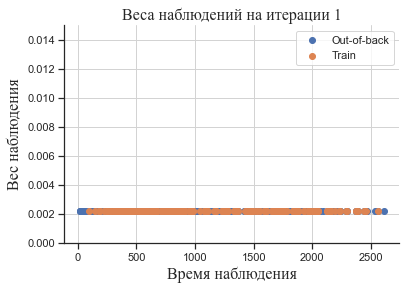

UNIQUE: (177,)


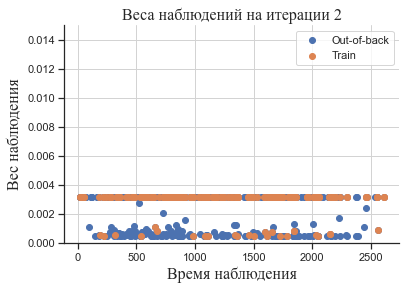

UNIQUE: (167,)


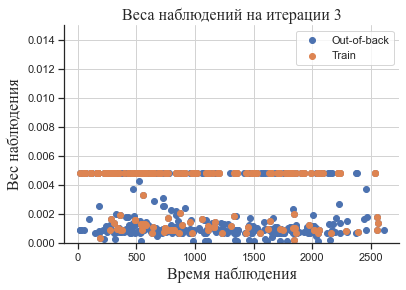

UNIQUE: (155,)


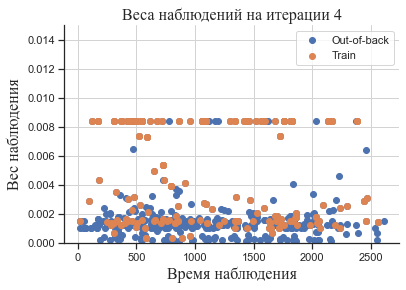

UNIQUE: (137,)


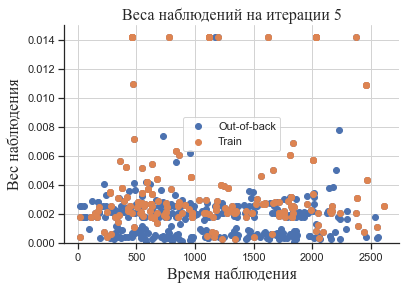

UNIQUE: (165,)


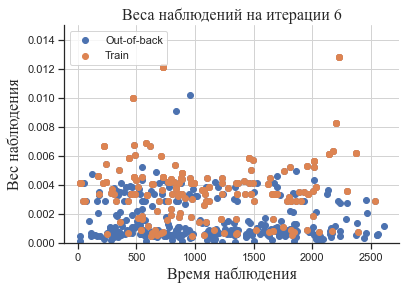

UNIQUE: (154,)


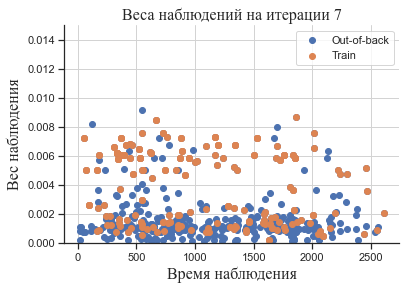

UNIQUE: (147,)


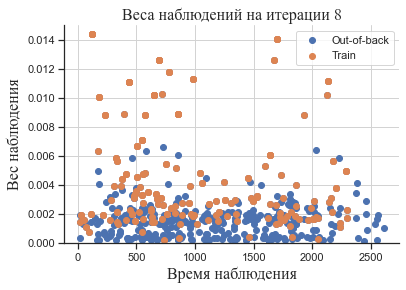

UNIQUE: (144,)


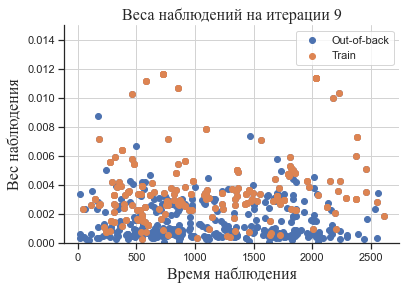

UNIQUE: (165,)


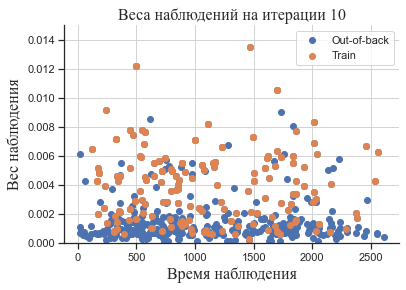

UNIQUE: (152,)
fitted: 10 models.


In [65]:
from survivors.ensemble import BootstrapCRAID, BoostingCRAID, IBSCleverBoostingCRAID

param_boost = {'aggreg_func': 'mean', 'all_weight': False, "mode_wei": "linear", 'balance': None, 'categ': ['htreat', 'menostat', 'tumgrad'], 
              'criterion': 'peto', 'depth': 7, 'ens_metric_name': 'IBS_REMAIN', 
              'l_reg': 0, 'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.01, 
              'n_estimators': 10, 'n_jobs': 5, 'size_sample': 0.5, 'weighted_tree': False}

bstr = BoostingCRAID1(**param_boost)
bstr.fit(X_tr, y_tr)

UNIQ INDEX: 284
UNIQ EVENT: 134
UNIQ CENS: 152


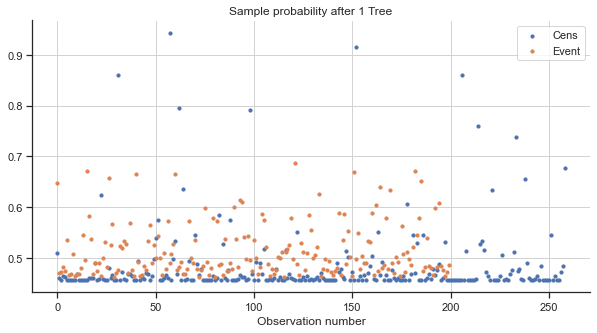

UNIQ INDEX: 295
UNIQ EVENT: 129
UNIQ CENS: 167


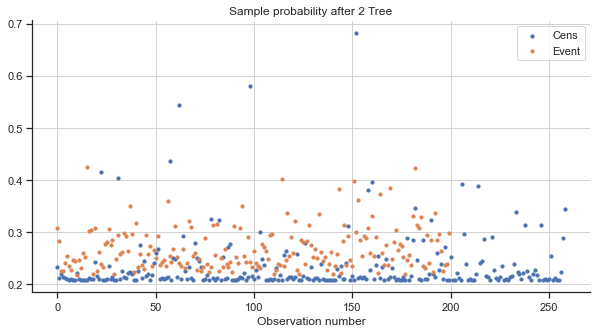

UNIQ INDEX: 276
UNIQ EVENT: 127
UNIQ CENS: 151


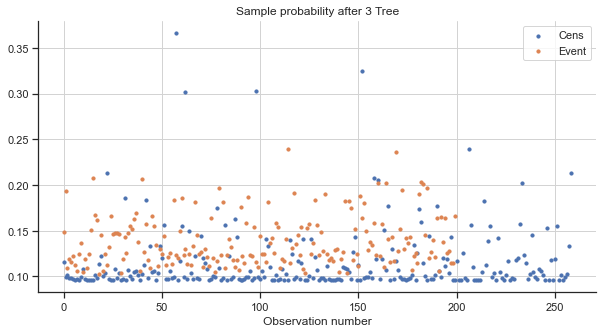

UNIQ INDEX: 280
UNIQ EVENT: 131
UNIQ CENS: 150


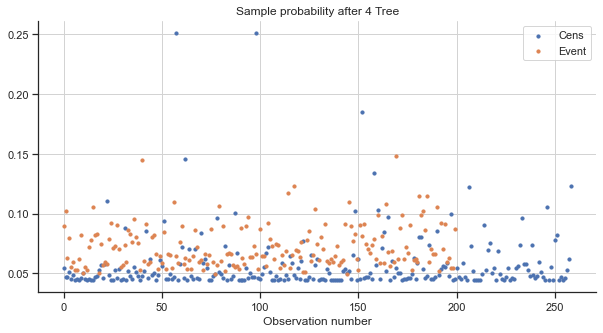

UNIQ INDEX: 284
UNIQ EVENT: 145
UNIQ CENS: 141


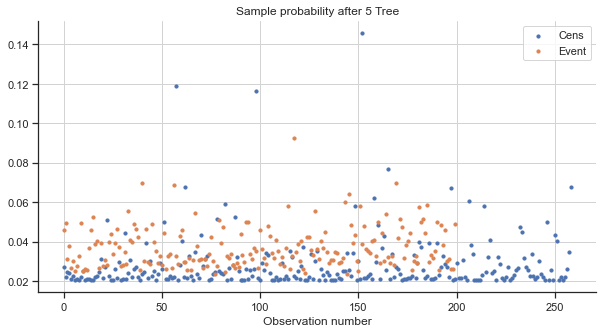

UNIQ INDEX: 281
UNIQ EVENT: 135
UNIQ CENS: 147


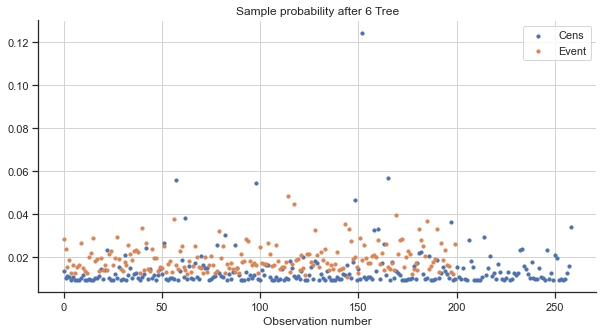

UNIQ INDEX: 272
UNIQ EVENT: 133
UNIQ CENS: 141


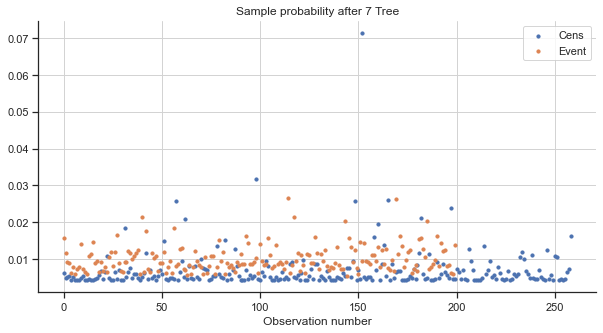

UNIQ INDEX: 271
UNIQ EVENT: 138
UNIQ CENS: 134


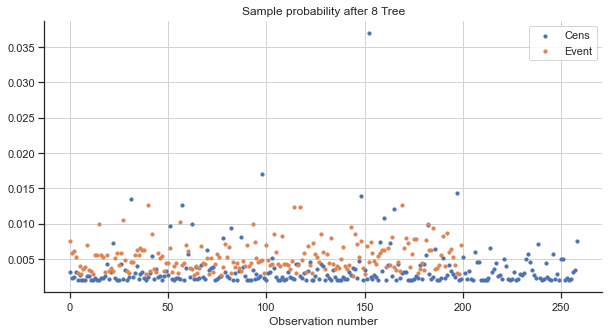

UNIQ INDEX: 268
UNIQ EVENT: 131
UNIQ CENS: 138


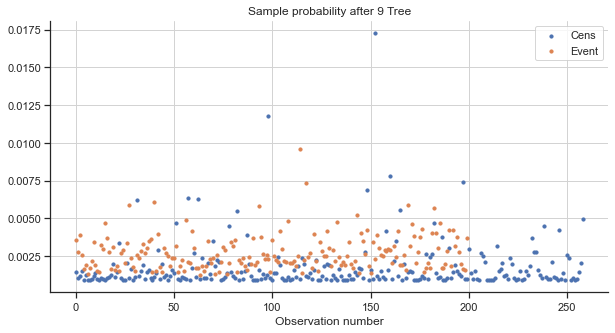

UNIQ INDEX: 265
UNIQ EVENT: 135
UNIQ CENS: 132


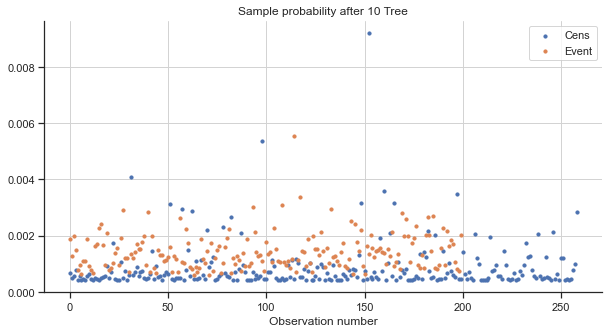

UNIQ INDEX: 244
UNIQ EVENT: 137
UNIQ CENS: 109


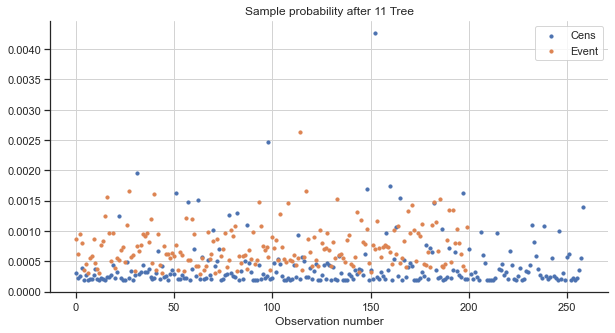

UNIQ INDEX: 265
UNIQ EVENT: 145
UNIQ CENS: 122


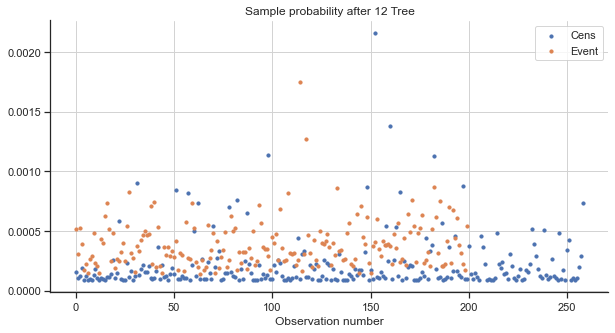

UNIQ INDEX: 262
UNIQ EVENT: 138
UNIQ CENS: 126


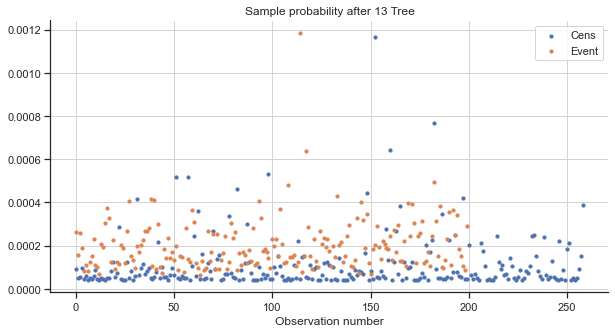

UNIQ INDEX: 244
UNIQ EVENT: 137
UNIQ CENS: 108


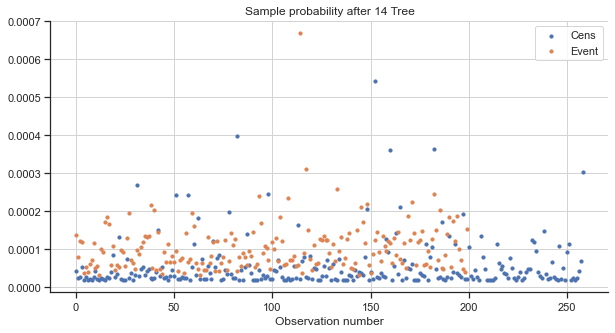

UNIQ INDEX: 238
UNIQ EVENT: 134
UNIQ CENS: 106


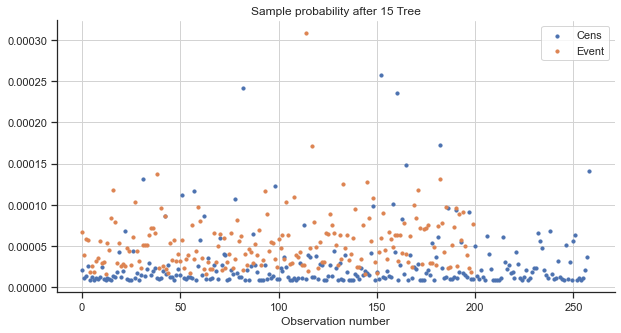

UNIQ INDEX: 236
UNIQ EVENT: 129
UNIQ CENS: 109


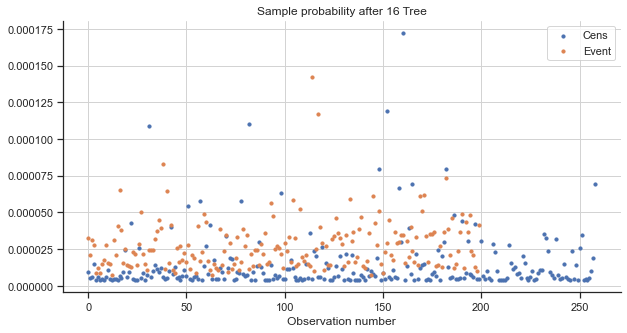

UNIQ INDEX: 240
UNIQ EVENT: 143
UNIQ CENS: 98


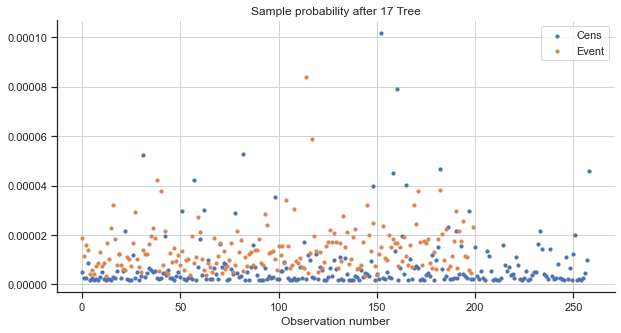

UNIQ INDEX: 231
UNIQ EVENT: 133
UNIQ CENS: 100


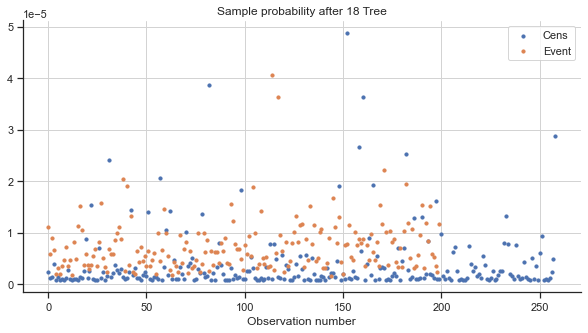

UNIQ INDEX: 230
UNIQ EVENT: 129
UNIQ CENS: 103


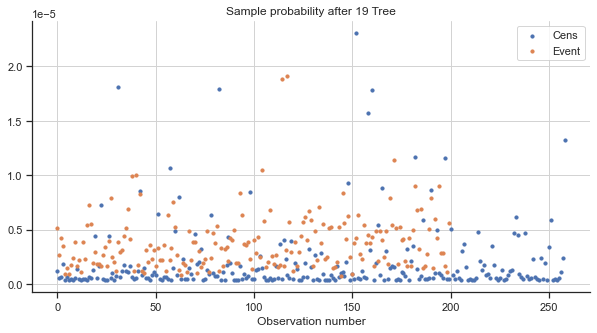

UNIQ INDEX: 220
UNIQ EVENT: 125
UNIQ CENS: 97


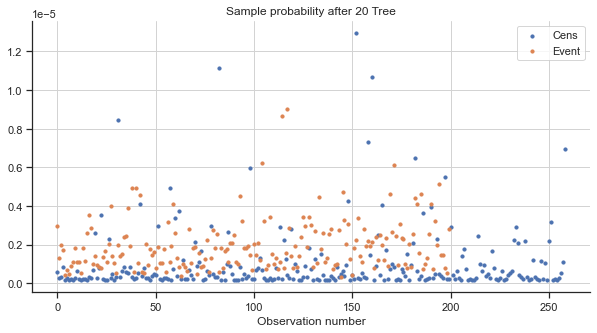

UNIQ INDEX: 225
UNIQ EVENT: 131
UNIQ CENS: 96


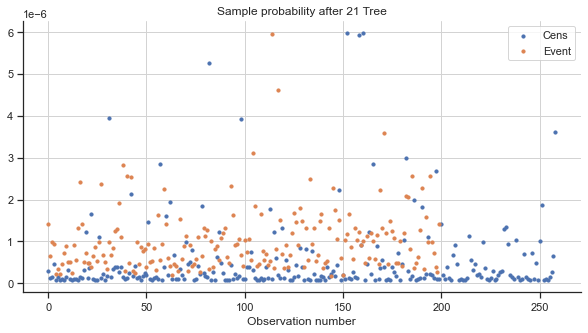

UNIQ INDEX: 219
UNIQ EVENT: 132
UNIQ CENS: 89


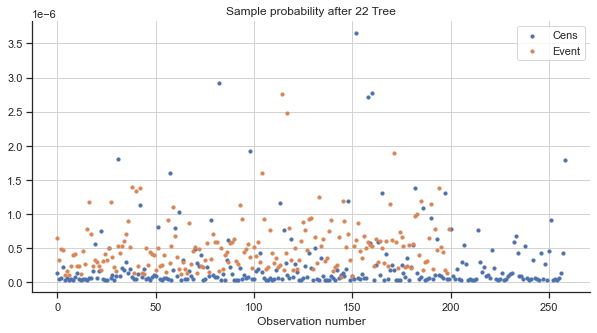

UNIQ INDEX: 218
UNIQ EVENT: 127
UNIQ CENS: 93


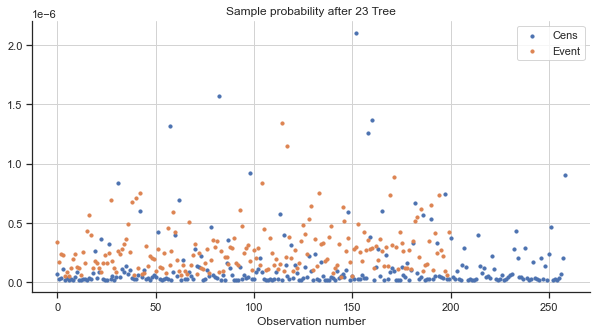

UNIQ INDEX: 215
UNIQ EVENT: 133
UNIQ CENS: 83


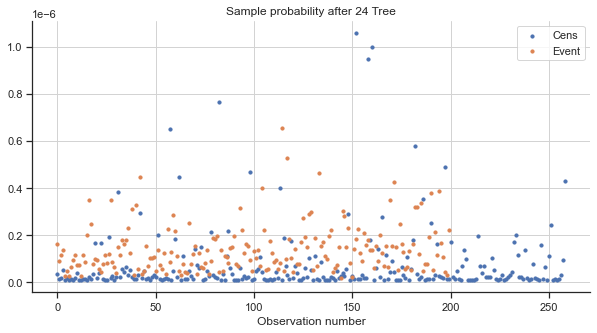

UNIQ INDEX: 211
UNIQ EVENT: 126
UNIQ CENS: 86


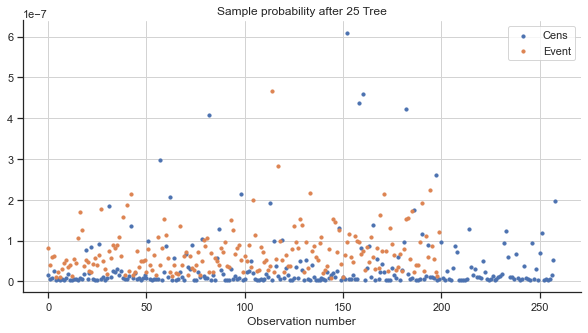

UNIQ INDEX: 221
UNIQ EVENT: 135
UNIQ CENS: 88


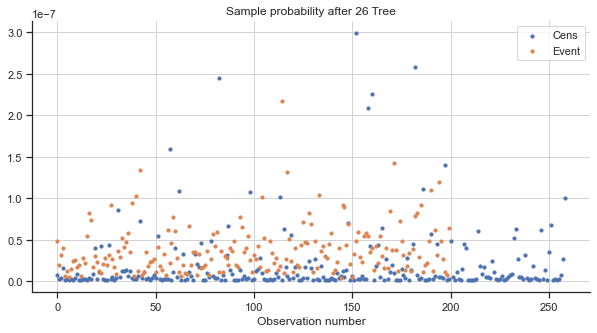

UNIQ INDEX: 197
UNIQ EVENT: 131
UNIQ CENS: 68


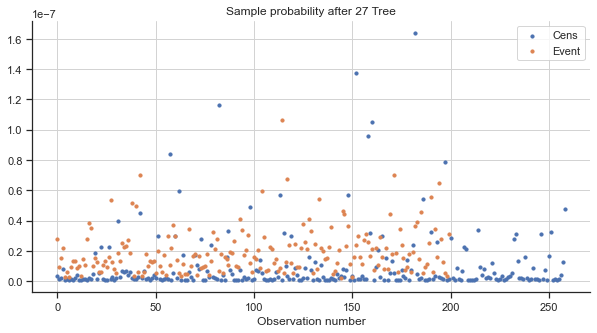

UNIQ INDEX: 206
UNIQ EVENT: 128
UNIQ CENS: 79


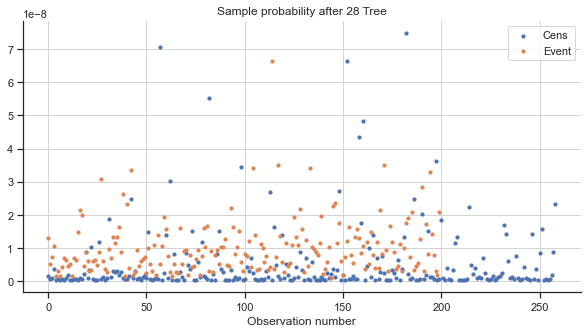

UNIQ INDEX: 197
UNIQ EVENT: 126
UNIQ CENS: 73


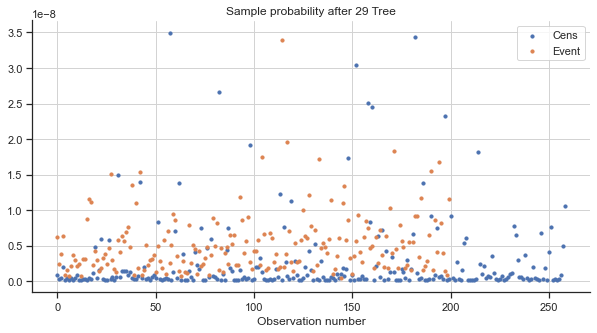

UNIQ INDEX: 200
UNIQ EVENT: 134
UNIQ CENS: 67


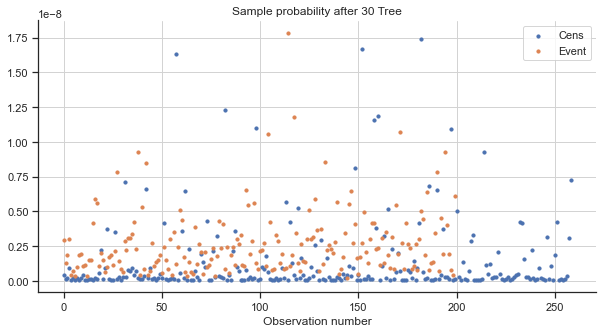

fitted: 30 models.


In [63]:
from survivors.ensemble import IBSProbBoostingCRAID
from survivors.ensemble.boosting import arc_x4

class BoostVisualizer(IBSProbBoostingCRAID):
    def update_weight(self, index, wei_i):
        super().update_weight(index, wei_i)
        self.visualize_weights(index)
    
    def visualize_weights(self, train_index):
        fig, axis = plt.subplots(figsize=(10, 5))
        print("UNIQ INDEX:", len(np.unique(train_index)))
        print("UNIQ EVENT:", len(np.unique(train_index * self.y_train[train_index]["cens"])))
        print("UNIQ CENS:", len(np.unique(train_index * (1 - self.y_train[train_index]["cens"]))))
        w = self.weights
        axis.set_title(f"Sample probability after {len(self.bettas)} Tree")
        axis.scatter(range(len(w[~self.y_train["cens"]])), 
                        w[~self.y_train["cens"]], 10, label = "Cens")
        axis.scatter(range(len(w[self.y_train["cens"]])), 
                        w[self.y_train["cens"]], 10, label = "Event")
        axis.set_xlabel("Observation number")
        axis.legend()
        plt.show()

proboost_params = {
 'balance': None, 
 "with_arc": False,
 'aggreg_func': 'wei', 'all_weight': True, 'categ': categ,
 'criterion': 'logrank', 'depth': 20, 'ens_metric_name': 'ibs', 
 'leaf_model': 'base', 'max_features': "sqrt", 'min_samples_leaf': 10, 
 'n_estimators': 30, 'n_jobs': 2, 'size_sample': 1.0
}

proboost = BoostVisualizer(**proboost_params)
proboost.fit(X_tr, y_tr)